In [1]:
#TODO: Need to refactor this file to use spikeforest_recording_utils.py

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install mountainlab_pytools

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/dl-project/Neuromorphic-BCI')
import os
import pandas as pd
import scipy.io
import numpy as np
from mountainlab_pytools.mdaio import readmda
from sklearn.preprocessing import minmax_scale
import random
import matplotlib.pyplot as plt
import csv

from encode import Differences, DownsampleSpace, DownsampleTime

In [5]:
##Initial Parameters for the entire suite of experiments
width = 16
n_bits = -1
horizontal_alignment = True
use_haar = False
asymmetric = False
if asymmetric:
    width = 19

#Only apply if first differences is used, picks how many values from the original data set should be used
# num_orig = 1
# orig_scale = 1

# orig = "recordings/MANUAL_FRANKLAB/manual_tetrode_600s/sorter1_1.raw.mda"
# filename = "recordings/MANUAL_FRANKLAB/manual_tetrode_600s/sorter1_1.firings_true.mda"

# Manual recordings
# orig = "/run/media/ksr/RAID/Downloads/spikeforest_recordings/recordings/MANUAL_FRANKLAB/manual_tetrode_600s/sorter1_1.raw.mda"
# filename = "/run/media/ksr/RAID/Downloads/spikeforest_recordings/recordings/MANUAL_FRANKLAB/manual_tetrode_600s/sorter1_1.firings_true.mda"
# channel_map = [1, 1, 2, 2, 0, 1, 3, 0, 3, 0, 3] #found manually

# orig = "/home/andrew/Neuromorphic-BCI/sorter1_2_600.raw.mda"
# filename = "/home/andrew/Neuromorphic-BCI/sorter1_2_600.firings_true.mda"
# channel_map = [1, 1, 2, 2, 0, 1, 3, 0, 3, 0, 3] #found manually

# orig = "/run/media/ksr/RAID/Downloads/spikeforest_recordings/recordings/MANUAL_FRANKLAB/manual_tetrode_600s/sorter2_4.raw.mda"
# filename = "/run/media/ksr/RAID/Downloads/spikeforest_recordings/recordings/MANUAL_FRANKLAB/manual_tetrode_600s/sorter2_4.firings_true.mda"
# channel_map = [3, 2, 1, 1, 2, 0, 2, 3] #found manually

# orig = "/run/media/ksr/RAID/Downloads/spikeforest_recordings/recordings/MANUAL_FRANKLAB/manual_tetrode_1200s/sorter3_1.raw.mda"
# filename = "/run/media/ksr/RAID/Downloads/spikeforest_recordings/recordings/MANUAL_FRANKLAB/manual_tetrode_1200s/sorter3_1.firings_true.mda"
# channel_map = [3, 2, 1, 2, 0, 1, 1]

# orig = "/run/media/ksr/RAID/Downloads/spikeforest_recordings/recordings/MANUAL_FRANKLAB/manual_tetrode_2400s/sorter3_1.raw.mda"
# filename = "/run/media/ksr/RAID/Downloads/spikeforest_recordings/recordings/MANUAL_FRANKLAB/manual_tetrode_2400s/sorter3_1.firings_true.mda"
# channel_map = [3, 2, 1, 2, 0, 1, 1]
orig = "/content/drive/MyDrive/dl-project/recording.mda"
filename = "/content/drive/MyDrive/dl-project/sorter1_1.firings_true.mda"
channel_map = [1, 1, 2, 2, 0, 1, 3, 0, 3, 0, 3]


In [6]:
"""
    Returns data[channel][time] of size width
    returns width sized waveform centered at index, unless this is at the edge. In the case of edges,
    150 samples up to the edge is considered (may cause interference if centering is needed)
"""
def get_waveform_at_time(orig, index, width):
    lower = index - (width+1) // 2
    upper = index + width // 2
    if asymmetric != False:
        width = 30 #Make width used as 19 in other places if asymmetric window is used
        lower = index - (width+1) // 10-1
        upper = index + width // 2
    if lower < 0:
        lower = 0
        upper = width
    if upper >= len(orig[0]):
        upper = len(orig[0]) - 1
    waveform = np.array([orig[c][lower:upper] for c in range(len(orig))])
    if not horizontal_alignment:
        return waveform

    for c in range(len(orig)):
        max_index = np.argmax(np.abs(waveform[c]- waveform[c][0]))
        # print("before: ", max_index, waveform[c][max_index]- waveform[c][0])
        horizontal_shift = max_index - len(waveform[c])//2
        # print(horizontal_shift, len(waveform[c]))
        waveform[c] = orig[c][lower+horizontal_shift:upper+horizontal_shift]
        max_index = np.argmax(np.abs(waveform[c]- orig[c][lower]))
        # print("after: ", max_index, waveform[c][max_index]- orig[c][lower], "\n\n")
    return waveform


In [7]:
"""Returns ---
    original_data[channel][timestep]
    spike_data[3][num_spikes]
    num_units: total unique types of spikes
    spike_index[unit][]: array of indices into spike_times for each unit. Eg, spike_index[0] is array of indices with all spikes of unit 0
    spike_times[]: array of actual index into original_data

    To get data for an entry in spike_times, use get_waveform_at_time(original_data, entry)
    Afaik, spike_data[0] is not useful
    spike_data[1] is a list of all indices into original_data with spikes
    spike_data[2] is a list of units each spike at times in spike_data[1] corresponds to a value in [1, num_units] )
    So, a spike at spike_data[1][t] is assigned to cluster stored in spike_data[2][t]

    Equivalently, spike_index is built to get a map from units to an index to spike_data[1]
        e.g spike_index[x][0] = t iff spike_data[2][t] = (x+1)
    """
def read_files(orig, filename):
    orig_data = readmda(orig)
    data = readmda(filename)
    print(f"original data: {orig_data}")
    num_units = len(np.unique(data[2])) # len(data[2]) is the number of spikes. data[2][i] represents the firing at data[1][i] belongs to unit data[2][i]. data[2] ranges from 0 to 10
    offset = 0 #Offset is 0 for manual dataset
    all_indices = [np.where(data[2] == x)[0] for x in range(offset, num_units + offset)] # all_indices[i] represents the all indices of unit i's spikes in data[2]
    all_times = data[1].astype(int) # len(data[1]) is the number of spikes. data[1][i] represents the time of spikes detected in orig_data
    return orig_data,data,num_units,all_indices,all_times

In [8]:
orig_data,data,num_units,all_indices,all_times = read_files(orig, filename)
num_channels = len(orig_data)
print(orig_data)
print(len(orig_data[0]))
print(all_indices[0])
print(len(all_times))

print(f"num_spikes: {len(all_times)} num actual_units: {num_units}, num_channels: {len(orig_data)}")

for i in range(num_units):
    print(i, len(all_indices[i]))

original data: [[-341 -372 -345 ...   23   46   90]
 [-285 -210 -239 ...  292  247  184]
 [-213 -209 -241 ...  196  243  240]
 [-267 -270 -293 ...  160  184  167]]
[[-341 -372 -345 ...   23   46   90]
 [-285 -210 -239 ...  292  247  184]
 [-213 -209 -241 ...  196  243  240]
 [-267 -270 -293 ...  160  184  167]]
72000000
[     0      1      2 ... 263092 263093 263094]
263095
num_spikes: 263095 num actual_units: 11, num_channels: 4
0 239141
1 1213
2 229
3 4237
4 2144
5 2588
6 2945
7 2782
8 2965
9 75
10 4776


In [9]:
# smoothing block
# def movingAvg(data, window_size, step_size):
#     moving_avg = []
#     for channel in data:
#         channel_window_avg = []
#         window_sum = sum(channel[:window_size])  # Initial sum of the first window
#         channel_window_avg.append(int(round(window_sum / window_size)))

#         for i in range(step_size, len(channel) - window_size + 1, step_size):
#             window_sum += sum(channel[i:i + step_size]) - sum(channel[i - step_size:i])
#             window_avg = int(round(window_sum / window_size))
#             channel_window_avg.append(window_avg)

#         moving_avg.append(channel_window_avg)

#     return moving_avg

# def average_downsample(array, new_size):
#     step = len(array[0]) // new_size
#     return np.array([np.mean(array[i, j:j+step]) for i in range(array.shape[0]) for j in range(0, array.shape[1], step)]).reshape(array.shape[0], new_size)


fraction = 1 / 4800
subset_length = int(orig_data.shape[1] * fraction)

# Slicing the first 1/20th from each row
reduced_data = orig_data[:, :subset_length]
#reduced_data = average_downsample(orig_data, 2000000)
print(len(reduced_data[0]))

15000


In [10]:
# Spike Detection MS4
import math

def detect_on_channel(data: np.ndarray, *, detect_threshold: float, detect_interval: float, detect_sign: int, margin: int=0):
    # Adjust the data to accommodate the detect_sign
    # After this adjustment, we only need to look for positive peaks
    if detect_sign < 0:
        data = data*(-1)
    elif detect_sign == 0:
        data = np.abs(data)
    elif detect_sign > 0:
        pass

    data = data.ravel()

    # An event at timepoint t is flagged if the following two criteria are met:
    # 1. The value at t is greater than the detection threshold (detect_threshold)
    # 2. The value at t is greater than the value at any other timepoint within plus or minus <detect_interval> samples

    # First split the data into segments of size detect_interval (don't worry about timepoints left over, we assume we have padding)
    N = len(data)
    S2 = math.floor(N / detect_interval)
    N2 = S2 * detect_interval
    data2 = np.reshape(data[0:N2], (S2, detect_interval))

    # Find the maximum on each segment (these are the initial candidates)
    max_inds2 = np.argmax(data2, axis=1)
    max_inds = max_inds2+detect_interval*np.arange(0, S2)
    max_vals = data[max_inds]

    # The following two tests compare the values of the candidates with the values of the neighbor candidates
    # If they are too close together, then discard the one that is smaller by setting its value to -1
    # Actually, this doesn't strictly satisfy the above criteria but it is close
    # TODO: fix the subtlety
    max_vals[np.where((max_inds[0:-1] >= max_inds[1:]-detect_interval)
                      & (max_vals[0:-1] < max_vals[1:]))[0]] = -1
    max_vals[1+np.array(np.where((max_inds[1:] <= max_inds[0:-1] +
                        detect_interval) & (max_vals[1:] <= max_vals[0:-1]))[0])] = -1

    # Finally we use only the candidates that satisfy the detect_threshold condition
    times = max_inds[np.where(max_vals >= detect_threshold)[0]]
    if margin > 0:
        times = times[np.where((times >= margin) & (times < N-margin))[0]]

    return times

In [11]:
# Spike detection with all neighborhoods MS4
from typing import Any, List, Tuple, Union, cast


def compute_sliding_maximum(X: np.ndarray, radius: int) -> Any:
    N = len(X)
    ret = np.zeros((N))
    for dt in range(-radius, radius+1):
        ret = np.maximum(ret, np.roll(X, dt))
    return ret

def getChunk(X, t1, t2, channels):
    if (t1 < 0) or (t2 > X.shape[1]):
        ret = np.zeros((len(channels), t2-t1))
        t1a = np.maximum(t1, 0)
        t2a = np.minimum(t2, X.shape[1])
        ret[:, t1a-(t1):t2a-(t1)] = getChunk(X = X, t1=t1a,
        t2=t2a, channels=channels)
        return ret
    else:
        return X[np.array(channels), t1:t2]


def detect_on_neighborhood_from_timeseries_model(X: Any, *, channel: int, nbhd_channels, detect_threshold: float, detect_sign: int, detect_interval: int, margin: int, chunk_infos: List[dict]) -> Tuple[np.ndarray, np.ndarray]:
    N = len(X[0])
    # The relative index of the central channel in the neighborhood
    channel_rel = np.where(nbhd_channels == channel)[0][0]

    times_list = []  # accumulate list of event times (one for each chunk)
    # accumulate list of assign_to_this_neighborhood lists (one for each chunk)
    assign_to_this_neighborhood_list = []

    padding = detect_interval*10

    for ii in range(len(chunk_infos)):
        chunk0 = chunk_infos[ii]
        X0 = getChunk(X = X, t1=chunk0['t1']-padding,
                        t2=chunk0['t2']+padding, channels=nbhd_channels)
        if detect_sign < 0:
            X0 *= -1
        elif detect_sign == 0:
            X0 = np.abs(X0)
        else:
            pass
        times0 = detect_on_channel(X0[channel_rel, :].ravel(
        ), detect_threshold=detect_threshold, detect_sign=1, detect_interval=detect_interval, margin=0)
        times0 = times0[np.where(
            (0 <= times0-padding) & (times0-padding < chunk0['t2']-chunk0['t1']))[0]]
        vals = X0[channel_rel, times0]
        nearby_neighborhood_maximum0 = compute_sliding_maximum(
            np.max(X0, axis=0).ravel(), radius=detect_interval)
        assign_to_this_neighborhood0 = (
            vals == nearby_neighborhood_maximum0[times0])
        times_list.append(times0-padding+chunk0['t1'])
        assign_to_this_neighborhood_list.append(assign_to_this_neighborhood0)

    times = cast(np.ndarray, np.concatenate(times_list))
    assign_to_this_neighborhood = cast(np.ndarray, np.concatenate(
        assign_to_this_neighborhood_list))

    return times, assign_to_this_neighborhood

sorting_opts = {
    "adjacency_radius": -1,
    "detect_sign": None,  # must be set explicitly
    "detect_interval": 10,
    "detect_threshold": 3,
    "num_features": 11,
    "max_num_clips_for_pca": 1000,
    'clip_size' : 0, # added
}

def create_chunk_infos(*, N: int, chunk_size: int):
    chunk_infos = []
    num_chunks = math.ceil(N/chunk_size)
    for i in range(num_chunks):
        chunk = {
            't1': i*chunk_size,
            't2': np.minimum(N, (i+1)*chunk_size)
        }
        chunk_infos.append(chunk)
    return chunk_infos

def get_channel_neighborhood(m: int, Geom: np.ndarray, *, adjacency_radius: float):
    M = Geom.shape[0]
    if adjacency_radius < 0:
        return np.arange(M)
    deltas = Geom-np.tile(Geom[m, :], (M, 1))
    distsqrs = np.sum(deltas**2, axis=1)
    inds = np.where(distsqrs <= adjacency_radius**2)[0]
    inds = np.sort(inds)
    return inds.ravel()

chunk_infos = create_chunk_infos(N=len(reduced_data[0]), chunk_size=100000)
# chunk_infos=create_chunk_infos(N=N,chunk_size=10000000)

m_central = Union[None, int]
for m in range(num_channels):
    m_central = m
geom = np.zeros((len(reduced_data), 2))

nbhd_channels = get_channel_neighborhood(
    m_central, geom, adjacency_radius=sorting_opts['adjacency_radius'])
M_neigh = len(nbhd_channels)

train_times = detect_on_neighborhood_from_timeseries_model(
                reduced_data, channel=m_central, nbhd_channels=nbhd_channels, detect_threshold=sorting_opts["detect_threshold"], detect_sign=-1, detect_interval=sorting_opts["detect_interval"], margin=sorting_opts['clip_size'], chunk_infos=chunk_infos)
#test_indices = [np.where(test_times == orig_data[0][x])[0] for x in range(0, len(orig_data[0]))]
print(train_times)
print([np.where(train_times[1] == True)])
print(len(train_times[0]))
#print(test_indices)
print(all_times)
print(len(all_times))

(array([    3,    14,    25,    49,    81,    92,   108,   145,   165,
         180,   200,   212,   240,   263,   280,   298,   316,   338,
         352,   364,   387,   402,   423,   447,   479,   504,   530,
         548,   566,   583,   596,   623,   637,   649,   678,   692,
         718,   743,   755,   781,   792,   807,   850,   874,   892,
         909,   927,   939,   957,   972,   983,  1007,  1064,  1076,
        1098,  1123,  1153,  1173,  1223,  1242,  1257,  1277,  1295,
        1313,  1325,  1360,  1414,  1797,  1811,  1948,  1977,  2541,
        2560,  2619,  2636,  2660,  2678,  2689,  2716,  2755,  2772,
        2784,  2803,  2815,  2826,  2838,  2861,  2880,  2892,  2911,
        2927,  2944,  2969,  2987,  3004,  3022,  3033,  3057,  3068,
        3092,  3105,  3396,  3414,  3434,  3471,  3484,  3508,  3521,
        3532,  3546,  3562,  3573,  3591,  3604,  3630,  3644,  3746,
        3757,  3776,  3800,  3821,  3845,  3858,  3871,  3882,  3906,
        3917,  3934

In [12]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh

# Assuming 'spike_times' is an array of spike event times obtained from your spike detection code
# and 'data' is the 4-channel tetrode data

# Step 1: Extract Spike Waveforms
window_size = 10
adjusted_spike_times = [t for t in train_times[0] if t - window_size // 2 >= 0 and t + window_size // 2 < orig_data.shape[1]]
spike_waveforms = np.array([orig_data[:, t - window_size // 2:t + window_size // 2] for t in adjusted_spike_times])

# spike_waveforms = get_waveform_at_time(orig_data, train_times[0], width)[channel]
#waveform =  get_waveform_at_time(data, time, width)[channel]
# np.array([orig_data[:, t - window_size // 2:t + window_size // 2] for t in train_times[0]])

# Step 2: Graph Construction
# Flatten waveforms for distance calculations
flattened_waveforms = spike_waveforms.reshape(spike_waveforms.shape[0], -1)
A = kneighbors_graph(flattened_waveforms, n_neighbors=5, mode='connectivity', include_self=True)
W = 0.5 * (A + A.T)  # Symmetrize the matrix

# Step 3: Laplacian Matrix
L = laplacian(W, normed=True)

# Step 4: Eigenvalue Decomposition
k = 11  # Number of eigenvectors to use
_, eigenvectors = eigsh(L, k=k, which='SM')

# Step 5: Feature Projection

print("Eigenvectors shape:", eigenvectors.shape)
print("Flattened waveforms shape:", flattened_waveforms.shape)
# features = flattened_waveforms @ eigenvectors
#features = np.dot(eigenvectors.T, flattened_waveforms)
laplacian_features = eigenvectors.T @ flattened_waveforms
print(laplacian_features)

# Now 'features' contains the Graph Laplacian features for each spike


Eigenvectors shape: (487, 11)
Flattened waveforms shape: (487, 40)
[[-7.68145137e+03 -7.70975911e+03 -8.07987184e+03 -8.17418019e+03
  -7.82049348e+03 -1.05126982e+04 -8.71361852e+03 -8.03975819e+03
  -8.21755155e+03 -7.93182410e+03 -6.82932089e+03 -6.92327138e+03
  -7.40891064e+03 -7.65825762e+03 -7.33218729e+03 -1.00577185e+04
  -8.16543502e+03 -7.40578171e+03 -7.64065357e+03 -7.35802640e+03
  -6.46403804e+03 -6.60384569e+03 -7.00008799e+03 -7.14604749e+03
  -6.80637290e+03 -9.22159016e+03 -7.32973626e+03 -6.97456825e+03
  -7.00881747e+03 -6.71566759e+03 -5.94793840e+03 -6.11217164e+03
  -6.59069764e+03 -6.89409322e+03 -7.02048328e+03 -9.80039858e+03
  -7.43519741e+03 -6.76578862e+03 -6.83321428e+03 -6.40947840e+03]
 [ 7.13277815e+03  7.31979074e+03  7.28063459e+03  7.25797918e+03
   7.45930571e+03  7.35467158e+03  7.33233776e+03  7.44556993e+03
   7.40243676e+03  7.21955709e+03  6.82063619e+03  7.14042062e+03
   7.14100794e+03  7.15665360e+03  7.31822887e+03  7.21490404e+03
   7.272

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


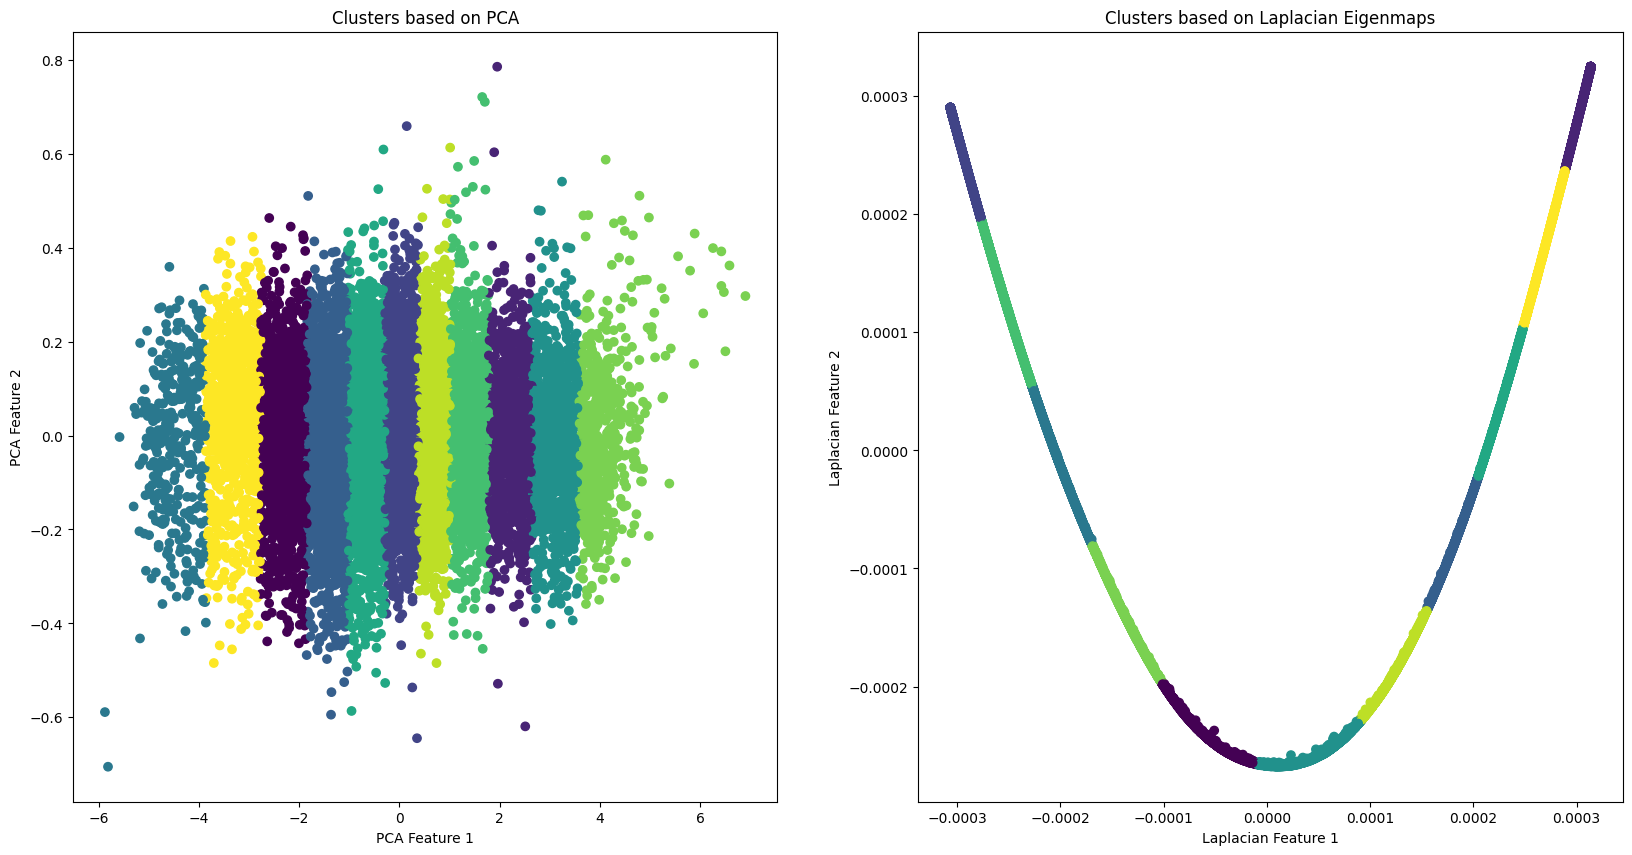

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.cluster import KMeans

# Assuming reduced_data is your dataset and is in the correct format

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(reduced_data.T)  # Transpose to get samples as rows

# PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Laplacian Eigenmaps for dimensionality reduction
laplacian = SpectralEmbedding(n_components=2, affinity='nearest_neighbors')
laplacian_result = laplacian.fit_transform(scaled_data)

# KMeans clustering
kmeans_pca = KMeans(n_clusters=11, random_state=0).fit(pca_result)
kmeans_laplacian = KMeans(n_clusters=11, random_state=0).fit(laplacian_result)

# Plotting the results side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# PCA clusters
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_pca.labels_, cmap='viridis')
axes[0].set_title('Clusters based on PCA')
axes[0].set_xlabel('PCA Feature 1')
axes[0].set_ylabel('PCA Feature 2')

# Laplacian clusters
axes[1].scatter(laplacian_result[:, 0], laplacian_result[:, 1], c=kmeans_laplacian.labels_, cmap='viridis')
axes[1].set_title('Clusters based on Laplacian Eigenmaps')
axes[1].set_xlabel('Laplacian Feature 1')
axes[1].set_ylabel('Laplacian Feature 2')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


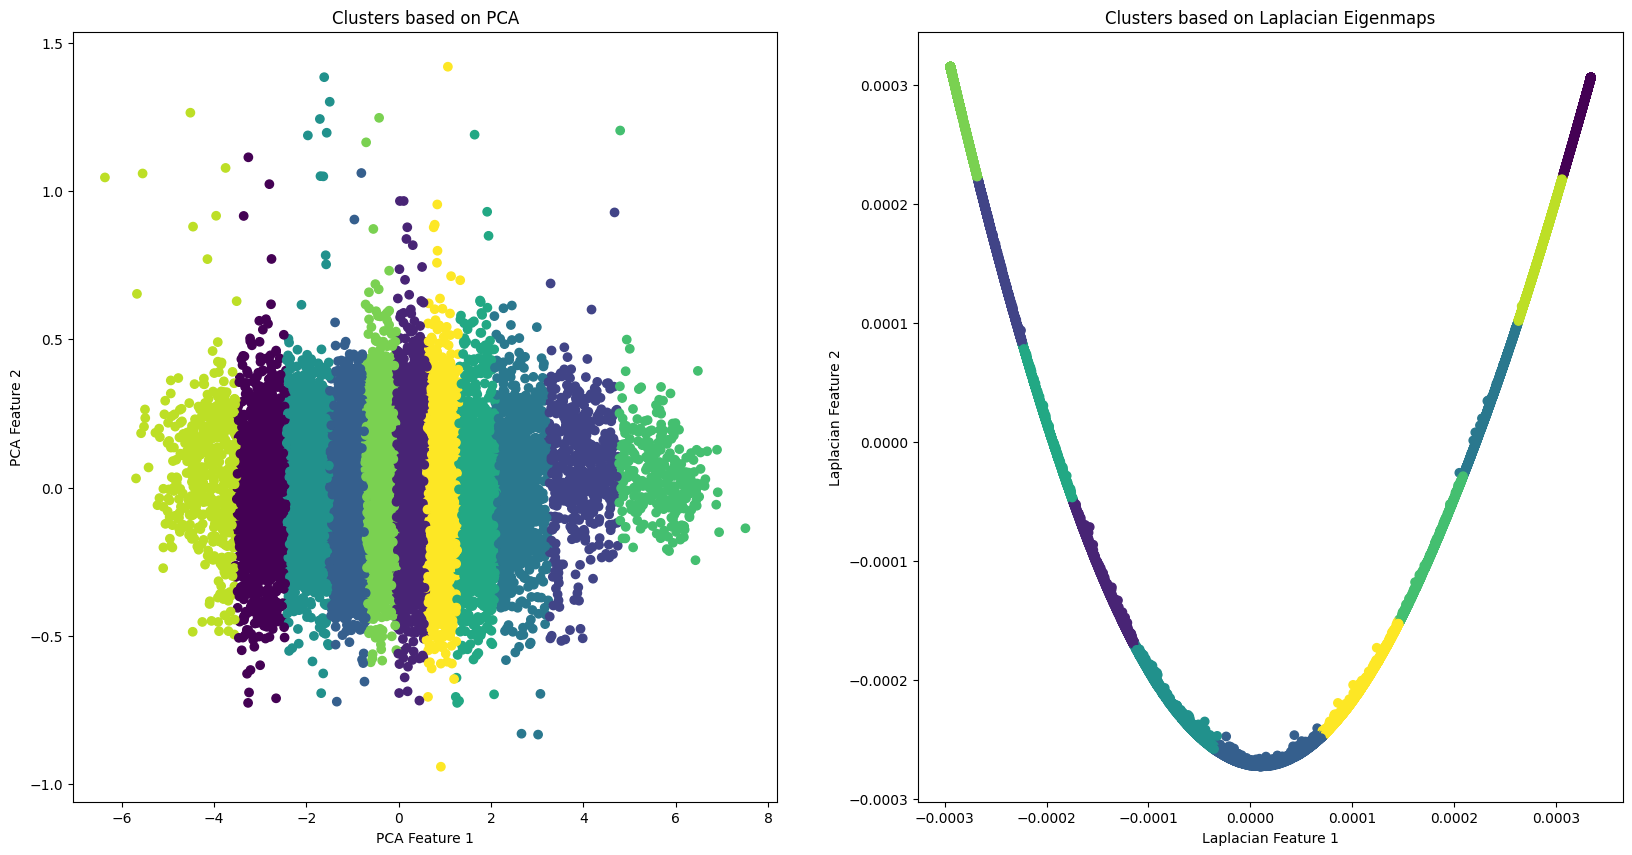

In [32]:
# look at the model's performance
reduced_data2 = orig_data[:, subset_length:2*subset_length]
# Scale the data
scaler = StandardScaler()
scaled_data2 = scaler.fit_transform(reduced_data2.T)  # Transpose to get samples as rows

# PCA for dimensionality reduction
pca_result2 = pca.fit_transform(scaled_data2)

# Laplacian Eigenmaps for dimensionality reduction
laplacian_result2 = laplacian.fit_transform(scaled_data2)
# KMeans clustering
kmeans_pca = KMeans(n_clusters=11, random_state=0).fit(pca_result2)
kmeans_laplacian = KMeans(n_clusters=11, random_state=0).fit(laplacian_result2)

# Plotting the results side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# PCA clusters
axes[0].scatter(pca_result2[:, 0], pca_result2[:, 1], c=kmeans_pca.labels_, cmap='viridis')
axes[0].set_title('Clusters based on PCA')
axes[0].set_xlabel('PCA Feature 1')
axes[0].set_ylabel('PCA Feature 2')

# Laplacian clusters
axes[1].scatter(laplacian_result2[:, 0], laplacian_result2[:, 1], c=kmeans_laplacian.labels_, cmap='viridis')
axes[1].set_title('Clusters based on Laplacian Eigenmaps')
axes[1].set_xlabel('Laplacian Feature 1')
axes[1].set_ylabel('Laplacian Feature 2')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


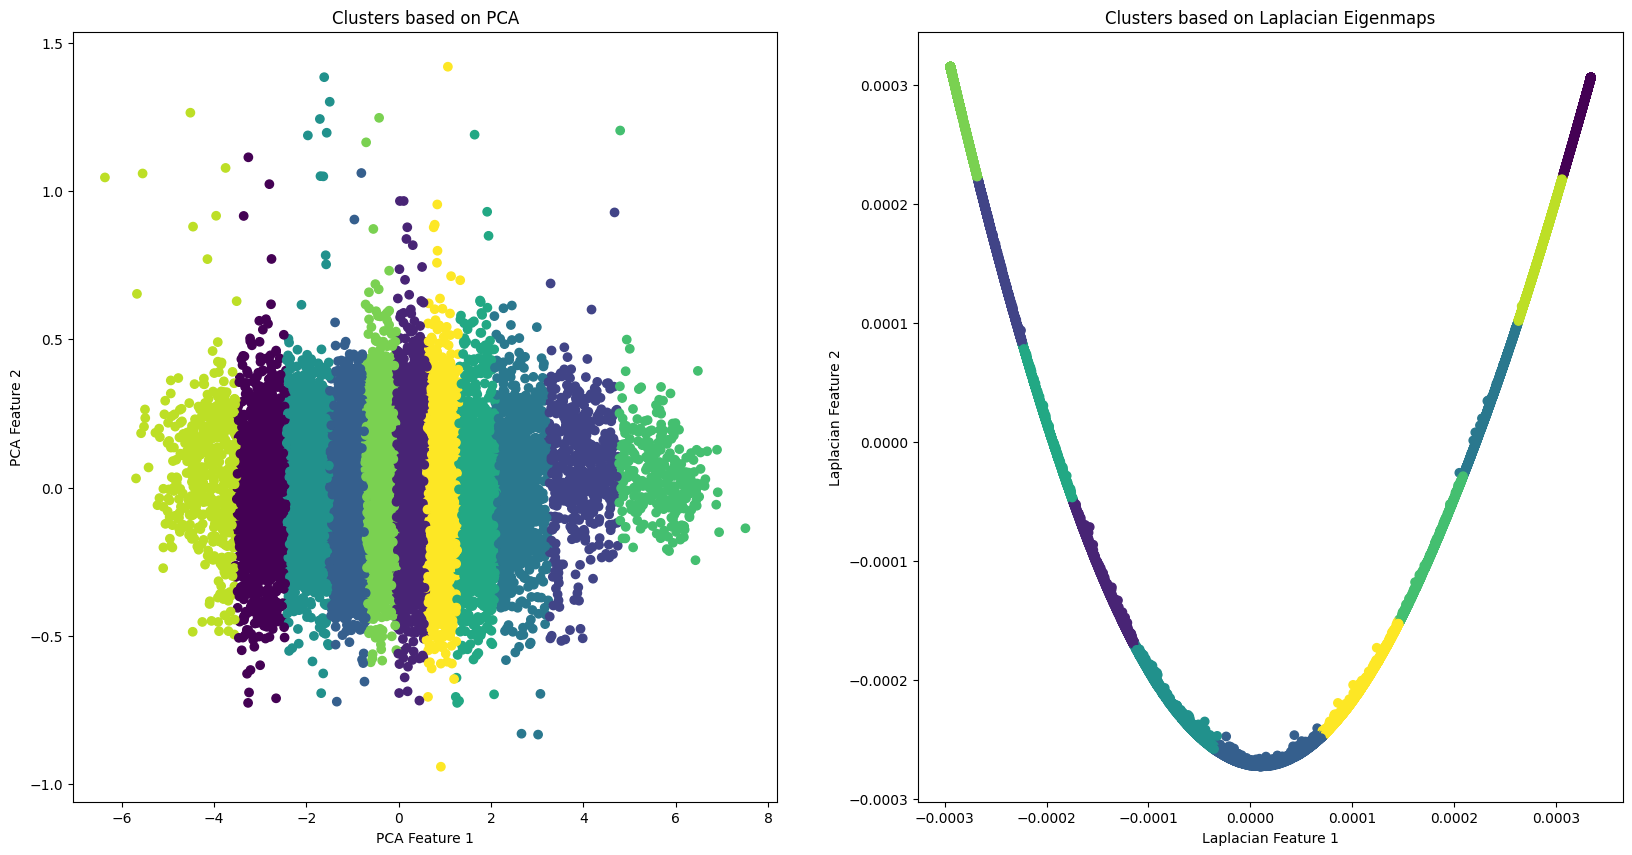

In [33]:
# look at the model's performance
reduced_data3 = orig_data[:, 2*subset_length:3*subset_length]
# Scale the data
scaler = StandardScaler()
scaled_data3 = scaler.fit_transform(reduced_data2.T)  # Transpose to get samples as rows

# PCA for dimensionality reduction
pca_result3 = pca.fit_transform(scaled_data3)

# Laplacian Eigenmaps for dimensionality reduction
laplacian_result3 = laplacian.fit_transform(scaled_data3)
# KMeans clustering
kmeans_pca = KMeans(n_clusters=11, random_state=0).fit(pca_result3)
kmeans_laplacian = KMeans(n_clusters=11, random_state=0).fit(laplacian_result3)

# Plotting the results side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# PCA clusters
axes[0].scatter(pca_result3[:, 0], pca_result3[:, 1], c=kmeans_pca.labels_, cmap='viridis')
axes[0].set_title('Clusters based on PCA')
axes[0].set_xlabel('PCA Feature 1')
axes[0].set_ylabel('PCA Feature 2')

# Laplacian clusters
axes[1].scatter(laplacian_result3[:, 0], laplacian_result3[:, 1], c=kmeans_laplacian.labels_, cmap='viridis')
axes[1].set_title('Clusters based on Laplacian Eigenmaps')
axes[1].set_xlabel('Laplacian Feature 1')
axes[1].set_ylabel('Laplacian Feature 2')

plt.show()

In [34]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette scores
silhouette_pca = silhouette_score(pca_result, kmeans_pca.labels_)
silhouette_laplacian = silhouette_score(laplacian_result, kmeans_laplacian.labels_)
silhouette_pca2 = silhouette_score(pca_result2, kmeans_pca.labels_)
silhouette_laplacian2 = silhouette_score(laplacian_result2, kmeans_laplacian.labels_)
silhouette_pca3 = silhouette_score(pca_result3, kmeans_pca.labels_)
silhouette_laplacian3 = silhouette_score(laplacian_result3, kmeans_laplacian.labels_)

# Calculate the mean and standard error across multiple runs
# This is a mock-up; replace with multiple silhouette scores from different runs
silhouettes_pca = [silhouette_pca, silhouette_pca2, silhouette_pca3]  # Replace with actual list of scores from different runs
silhouettes_laplacian = [silhouette_laplacian, silhouette_laplacian2, silhouette_laplacian3]  # Replace with actual list of scores from different runs

mean_silhouette_pca = np.mean(silhouettes_pca)
se_silhouette_pca = np.std(silhouettes_pca) / np.sqrt(len(silhouettes_pca))

mean_silhouette_laplacian = np.mean(silhouettes_laplacian)
se_silhouette_laplacian = np.std(silhouettes_laplacian) / np.sqrt(len(silhouettes_laplacian))

# Display the results
print(f"PCA Clustering: Mean Silhouette Score = {mean_silhouette_pca:.2f} +/- {se_silhouette_pca:.2f}")
print(f"Laplacian Clustering: Mean Silhouette Score = {mean_silhouette_laplacian:.2f} +/- {se_silhouette_laplacian:.2f}")


PCA Clustering: Mean Silhouette Score = 0.18 +/- 0.18
Laplacian Clustering: Mean Silhouette Score = 0.34 +/- 0.20


In [ ]:
# Spike detection MS5 - yet to be implemented fully

from typing import Tuple, Union
import numpy as np
import numpy.typing as npt


def detect_spikes(
    traces: npt.NDArray[np.float32], *,
    channel_locations: npt.NDArray[np.float32],
    time_radius: int,
    channel_radius: Union[float, None],
    detect_threshold: float,
    detect_sign: int,
    margin_left: int,
    margin_right: int,
    verbose: bool
) -> Tuple[npt.NDArray[np.int32], npt.NDArray[np.int32]]:
    N = traces.shape[0]
    M = traces.shape[1]

    if detect_sign > 0:
        # todo: figure out how to avoid making a copy
        traces = -traces # pragma: no cover
    elif detect_sign == 0:
        # todo: figure out how to avoid making a copy
        traces = -np.abs(traces) # pragma: no cover

    adjacency = []
    for m in range(M):
        adjacency.append([])
        for m2 in range(M):
            dist0 = np.sqrt(np.sum((channel_locations[m] - channel_locations[m2]) ** 2))
            if (channel_radius is None) or (dist0 <= channel_radius):
                adjacency[m].append(m2)
    print('')
    print(f'Adjacency for detect spikes with channel radius {channel_radius}')
    print(adjacency)
    print('')

    inds1, inds2 = np.nonzero(traces <= -detect_threshold)

    candidate_times = [[] for m in range(M)]
    candidate_values = [[] for m in range(M)]
    for i in range(len(inds1)):
        if inds1[i] >= margin_left and inds1[i] < N - margin_right:
            candidate_times[inds2[i]].append(inds1[i])
            candidate_values[inds2[i]].append(traces[inds1[i], inds2[i]])

    times = []
    channel_indices = []
    for m in range(M):
        nbhd = adjacency[m]
        if verbose:
            print(f'm = {m} (nbhd size: {len(nbhd)})')
        indices = [0 for j in range(len(nbhd))]
        for i in range(len(candidate_times[m])):
            t = candidate_times[m][i]
            v = candidate_values[m][i]
            okay = True
            for j in range(len(nbhd)):
                if not okay:
                    break
                tt = candidate_times[nbhd[j]]
                vv = candidate_values[nbhd[j]]
                ii = indices[j]
                while ii < len(tt) and tt[ii] < t - time_radius:
                    ii += 1
                indices[j] = ii # advance
                jj = ii
                while jj < len(tt) and tt[jj] <= t + time_radius:
                    if vv[jj] < v:
                        okay =False
                        break
                    jj += 1
            if okay:
                times.append(t)
                channel_indices.append(m)

    times = np.array(times, dtype=np.int32)
    channel_indices = np.array(channel_indices, dtype=np.int32)
    inds = np.argsort(times)
    times = times[inds]
    channel_indices = channel_indices[inds]
    return times, channel_indices

In [ ]:
def process_waveform(data, time, channel, use_differences = 0, width=width, use_haar=use_haar):
    waveform =  get_waveform_at_time(data, time, width)[channel] #given a time, return the waveform from surrounding width of a spike
    if use_differences:
        make_diffs = Differences(1)
        waveform = make_diffs(waveform)
    else:
        waveform -= waveform[0]
    if not use_haar or use_differences or asymmetric:
        return waveform

    #Haar transform
    new_waveform = [0]*width
    for i in range(0, width//2):
        new_waveform[i] = (waveform[2*i]+waveform[2*i+1])/2
        new_waveform[i+width//2] = (waveform[2*i]-waveform[2*i+1])/2
    return np.array(new_waveform)

def downsample_orig_data(orig_data, n_bits):
    if n_bits != -1:
        downsample_space = DownsampleSpace(n_bits=n_bits)
        return downsample_space(orig_data)
    return orig_data

Nueron 0


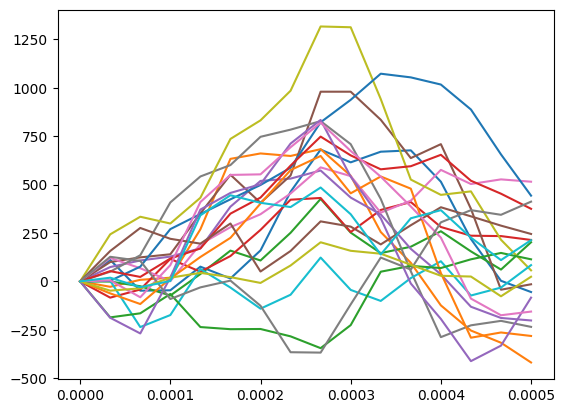

Nueron 1


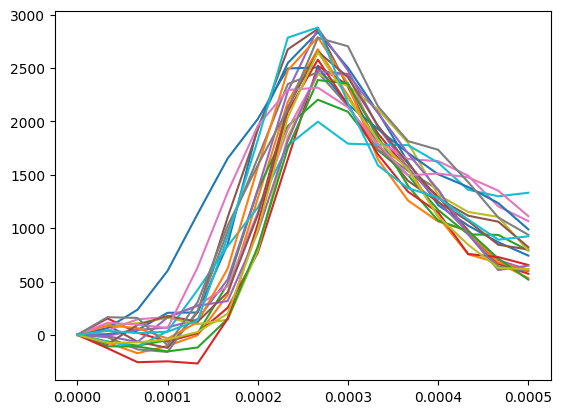

Nueron 2


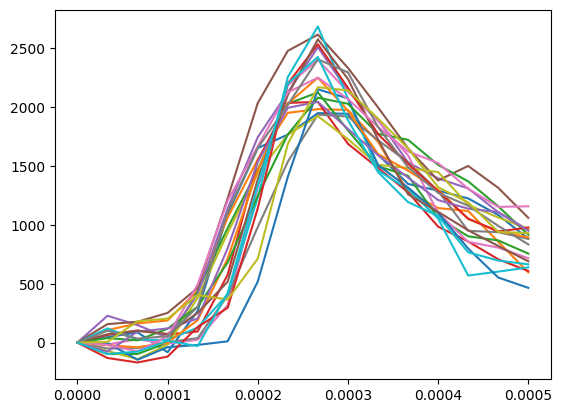

Nueron 3


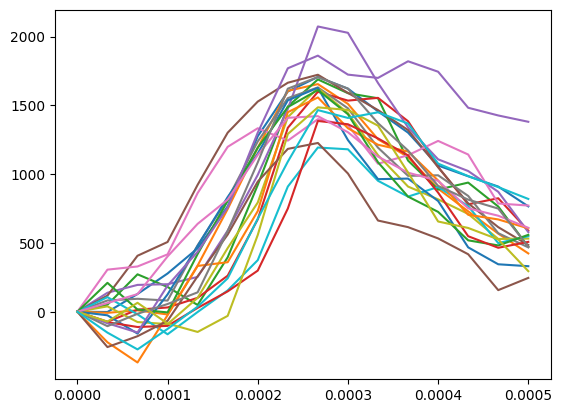

Nueron 4


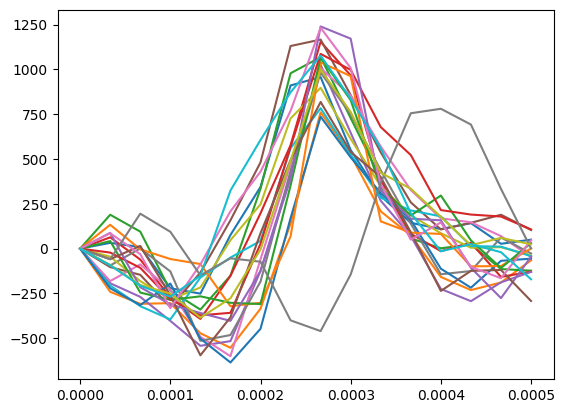

Nueron 5


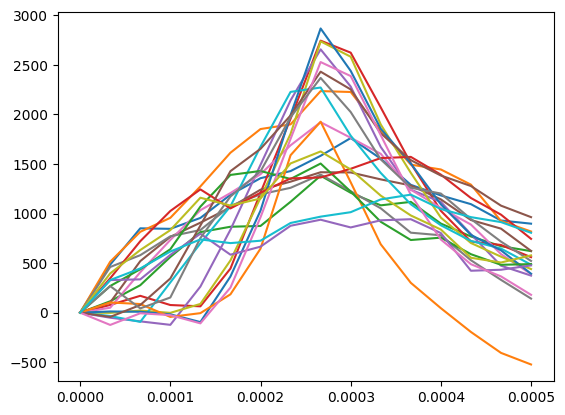

Nueron 6


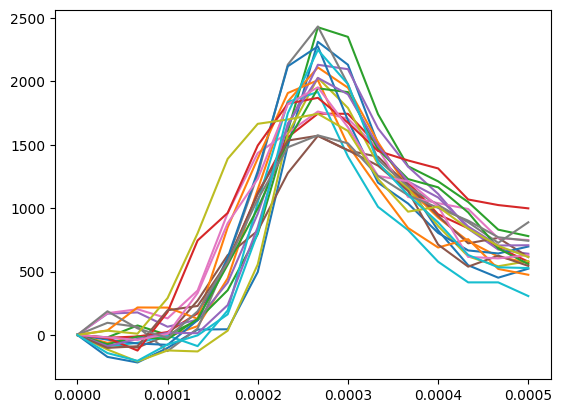

Nueron 7


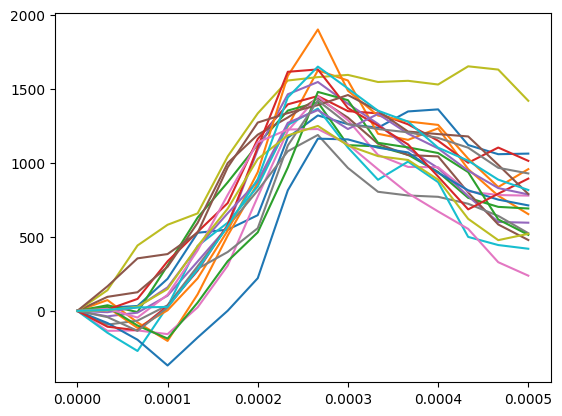

Nueron 8


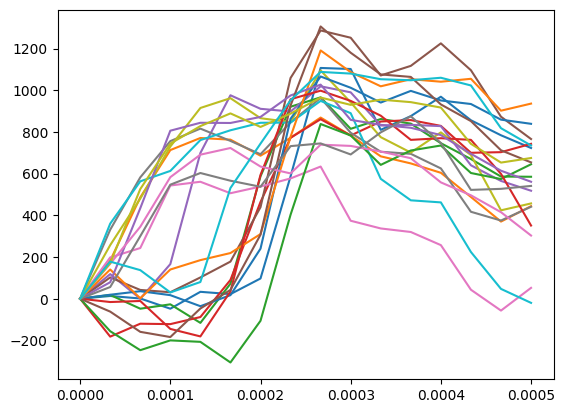

Nueron 9


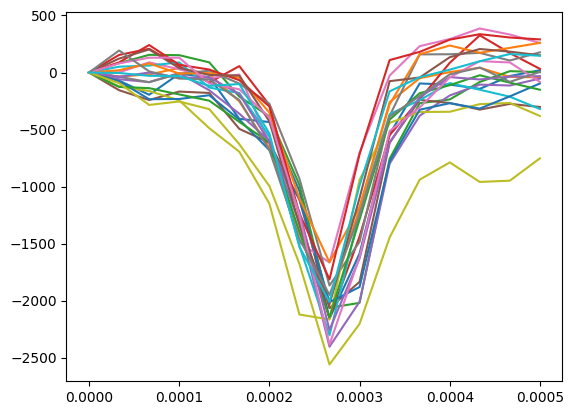

Nueron 10


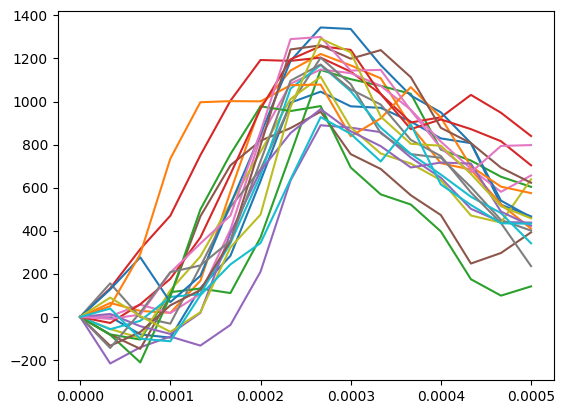

In [ ]:
#Print a random sample of spikes for each neuron from the original data
plt.figure(facecolor='white')
downsampled_data = downsample_orig_data(orig_data, n_bits)
use_differences = 0
for neuron in range(num_units):
    print("Nueron", neuron)
    # all_indices[unit][]: array of indices into spike_times for each unit. Eg, spike_index[0] is array of indices with all spikes of unit 0
    for col, index in enumerate(random.sample(list(all_indices[neuron]), min(20, len(all_indices[neuron])))): # sampling 20 from all spikes of a neuron
        waveform =  process_waveform(downsampled_data, all_times[index], channel_map[neuron], use_differences, width, use_haar)
        plt.plot(np.arange(0, len(waveform) / 30000, 1 / 30000), waveform*-1)
    plt.show()

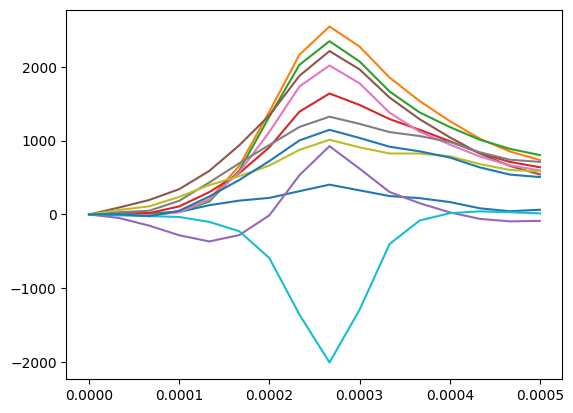

In [ ]:
use_differences = 0
downsampled_data = downsample_orig_data(orig_data, n_bits)
# width=19
# Print average waveform for units in all channels (only used to determine best channel per unit)
# plt.figure(facecolor='white')
# for i in range(num_units):
#     print("Unit", i)
#     for k in range(num_channels):
#         s = np.zeros(width-use_differences)
#         for index in all_indices[i]:
#             waveform =  process_waveform(downsampled_data, all_times[index], k, use_differences)
#             s += waveform
#         s = s/len(all_indices[i])
#         plt.plot(np.arange(0, len(s) / 30000, 1/30000), s*-1, label=str(k))
#         plt.legend()
#     plt.show()
# channel_map = [3, 2, 1, 1, 2, 0, 2, 3] #found manually

#Print single plot of centroid waveform for each unit on the correct channel
plt.figure(facecolor='white')
for i in range(num_units):
    s = np.zeros(width-use_differences)
    for index in all_indices[i]:
        waveform =  process_waveform(downsampled_data, all_times[index], channel_map[i], use_differences)
        s += waveform
    s = s/len(all_indices[i]) # average waveform is the centroid
    plt.plot(np.arange(0, len(s) / 30000, 1/30000), s*-1, label=str(i))
    # plt.legend()
plt.show()


In [ ]:
show_details = True

def compute_centroids(channel_map, use_differences, n_bits=n_bits, width=width, use_first=1, use_haar=use_haar):
    centroids = []
    downsampled_data = downsample_orig_data(orig_data, n_bits)

    #First compute centroids
    for i in range(use_first, num_units):
        s = np.zeros(width-use_differences)
        for index in all_indices[i]:
            waveform =  process_waveform(downsampled_data, all_times[index], channel_map[i], use_differences, width, use_haar)
            s += waveform
        s = s/len(all_indices[i])
        centroids.append(s)

    return centroids

# Returns the index of the centroid that is closest to the waveform as well as the min/actual distance of this waveform to a centroid
# The actual distance refers to the distance to the centroid for the unit that the ground truth says the waveform is for
def get_closest_centroid(centroids, waveform, distance_metric, actual_unit, use_first=1):
    min_distance = -1
    min_centroid_index = -1 #min_centroid_index will be use_first behind the neuron index
    actual_dist = 0
    for j, centroid in enumerate(centroids):
        if distance_metric == "MANHATTAN":
            dist = round(sum(map(abs, waveform - centroid))/len(waveform), 3) #manhattan
        else:
            dist = round(sum(map(lambda x: x*x, waveform - centroid))**(1/2)/len(waveform), 3) #euclidean
        if min_distance == -1 or dist < min_distance:
            min_distance = dist
            min_centroid_index = j
        if actual_unit-use_first == j:
            actual_dist = dist
    return min_centroid_index, min_distance, actual_dist

def compute_algorithmic_accuracy(channel_map, use_differences, distance_metric, n_bits=n_bits, width=width, use_first=1, use_haar=use_haar):
    centroids = compute_centroids(channel_map, use_differences, n_bits, width, use_first, use_haar)

    #Compute algorithmic accuracy with nearest centroid
    num_matched = 0
    num_total = 0
    count = 0
    details = []
    if use_first:
        details.append([])
    for i in range(use_first, num_units):
        matches = [0]*num_units
        neuron_total = 0
        s = np.zeros(width-use_differences)
        for index in all_indices[i]:
            waveform =  process_waveform(downsampled_data, all_times[index], channel_map[i], use_differences, width, use_haar)
            min_centroid_index, min_distance, actual_dist = get_closest_centroid(centroids, waveform, distance_metric, i, use_first)
            if  i - use_first == min_centroid_index:
                num_matched += 1
            # else:
            #     #plot of 10 unmatched spike samples
            #     if show_details:
            #         if count < 10:
            #             print(f"---------------------------------------------------\
            #                     \nunit {i}, time index {index}, closest centroid unit {min_centroid_index+use_first}, dists: {min_distance} < {actual_dist}")
            #             plt.plot(np.arange(0, len(waveform) / 30000, 1/30000), waveform*-1, label="spike")
            #             plt.legend()
            #             plt.plot(np.arange(0, len(centroids[min_centroid_index]) / 30000, 1/30000), centroids[min_centroid_index]*-1, label="closest centroid")
            #             plt.legend()
            #             plt.plot(np.arange(0, len(centroids[i-use_first]) / 30000, 1/30000), centroids[i-use_first]*-1, label="actual centroid")
            #             plt.legend()
            #             plt.show()
            #             count += 1
            matches[min_centroid_index+use_first] += 1
            num_total += 1
            neuron_total += 1
        if show_details:
            details.append(matches)
            print("Unit", i, matches, round(matches[i]/neuron_total, 3), matches[i], neuron_total)
    if show_details:
        print(f"Accuracy {use_differences, distance_metric, use_first, n_bits}:", round(num_matched/num_total, 3), num_matched, num_total)
        return details
    return num_matched/num_total


In [ ]:
def tabulate_experiment(channel_map, file_name, function, headers, params):
    print(file_name)
    # open csv file in write mode
    with open(file_name, 'w') as f:
        # create the csv writer
        writer = csv.writer(f)
        writer.writerow(headers)

        indices = [0]*len(params)
        while True:
            # print(indices)
            row = [params[i][indices[i]] for i in range(len(params))]
            print([channel_map]+row)
            row.append(round(function(*([channel_map]+row)), 3))
            writer.writerow(row)

            curr_param = 0
            while curr_param < len(params) and indices[curr_param] == len(params[curr_param]) - 1:
                indices[curr_param] = 0
                curr_param += 1
            if curr_param == len(params):
                break
            indices[curr_param] += 1


In [ ]:
use_differences = 0
distance_metric = "EUCLIDEAN" #Could be EUCLIDEAN or MANHATTAN

# [[1, 1, 2, 2, 0, 1, 3, 0, 3, 0, 3], 0, 'EUCLIDEAN', 0, 15, -1]
# compute_algorithmic_accuracy(channel_map, 0, "EUCLIDEAN", 1, 15, -1)
# Try out different encodings, probably need to update with num_orig, orig_scale at some point
# csv_name = filename[filename.find("recordings/")+len("recordings/"):filename.find(".firings_true")].replace("/", "-") + "-Nearest Centroids.csv"
# tabulate_experiment(channel_map, csv_name, compute_algorithmic_accuracy, ["First Differences", "Distance Metric", "Precision", "Width", "Use First", "Algorithmic Accuracy"], [
#     [0, 1],
#     ["EUCLIDEAN", "MANHATTAN"],
#     [-1, 8],
#     [15, 30, 50],
#     [0, 1],
# ])

# channel_map, use_differences, distance_metric, n_bits=-1, width=30, use_first=1
# compute_algorithmic_accuracy(channel_map, 0, "EUCLIDEAN", -1, 30, 0)
# compute_algorithmic_accuracy(channel_map, 1, "EUCLIDEAN", -1, 30, 0)
# compute_algorithmic_accuracy(channel_map, 0, "MANHATTAN", -1, 30, 0)
# compute_algorithmic_accuracy(channel_map, 1, "MANHATTAN", -1, 30, 0)
# compute_algorithmic_accuracy(channel_map, 0, "EUCLIDEAN", 8, 30, 0)
# compute_algorithmic_accuracy(channel_map, 1, "EUCLIDEAN", 8, 30, 0)
# compute_algorithmic_accuracy(channel_map, 0, "MANHATTAN", 8, 30, 0)
# compute_algorithmic_accuracy(channel_map, 1, "MANHATTAN", 8, 30, 0)

# details = compute_algorithmic_accuracy(channel_map, 0, "EUCLIDEAN", -1, 30, 1)
# compute_algorithmic_accuracy(channel_map, 0, "MANHATTAN", -1, 30, 1)
details = compute_algorithmic_accuracy(channel_map, 0, "EUCLIDEAN", -1, 16, 1, False)
# compute_algorithmic_accuracy(channel_map, 1, "MANHATTAN", -1, 30, 1)
# compute_algorithmic_accuracy(channel_map, 0, "EUCLIDEAN", 8, 30, 1)
# compute_algorithmic_accuracy(channel_map, 1, "EUCLIDEAN", 8, 30, 1)
# compute_algorithmic_accuracy(channel_map, 0, "MANHATTAN", 8, 30, 1)
# compute_algorithmic_accuracy(channel_map, 1, "MANHATTAN", 8, 30, 1)


Unit 1 [0, 810, 203, 2, 4, 74, 118, 0, 0, 0, 2] 0.668 810 1213
Unit 2 [0, 74, 107, 1, 2, 17, 27, 0, 0, 0, 1] 0.467 107 229
Unit 3 [0, 6, 92, 2477, 26, 323, 323, 423, 11, 0, 556] 0.585 2477 4237
Unit 4 [0, 0, 0, 0, 2031, 0, 0, 1, 7, 74, 31] 0.947 2031 2144
Unit 5 [0, 751, 118, 23, 18, 1065, 175, 341, 80, 0, 17] 0.412 1065 2588
Unit 6 [0, 29, 407, 449, 10, 338, 1615, 53, 0, 0, 44] 0.548 1615 2945
Unit 7 [0, 0, 7, 413, 7, 52, 2, 1581, 167, 0, 553] 0.568 1581 2782
Unit 8 [0, 0, 1, 49, 94, 1, 2, 539, 1415, 1, 863] 0.477 1415 2965
Unit 9 [0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 0] 1.0 75 75
Unit 10 [0, 0, 0, 77, 56, 2, 0, 880, 533, 0, 3228] 0.676 3228 4776
Accuracy (0, 'EUCLIDEAN', 1, -1): 0.601 14404 23954


[[], [0, 810, 203, 2, 4, 74, 118, 0, 0, 0, 2], [0, 74, 107, 1, 2, 17, 27, 0, 0, 0, 1], [0, 6, 92, 2477, 26, 323, 323, 423, 11, 0, 556], [0, 0, 0, 0, 2031, 0, 0, 1, 7, 74, 31], [0, 751, 118, 23, 18, 1065, 175, 341, 80, 0, 17], [0, 29, 407, 449, 10, 338, 1615, 53, 0, 0, 44], [0, 0, 7, 413, 7, 52, 2, 1581, 167, 0, 553], [0, 0, 1, 49, 94, 1, 2, 539, 1415, 1, 863], [0, 0, 0, 0, 0, 0, 0, 0, 0, 75, 0], [0, 0, 0, 77, 56, 2, 0, 880, 533, 0, 3228]]
---------------------------------------------------                        
Different Bucket: Actual unit 1, Closest centroid unit 3, Number of spikes 47, Average dists 21.28 < 26.908


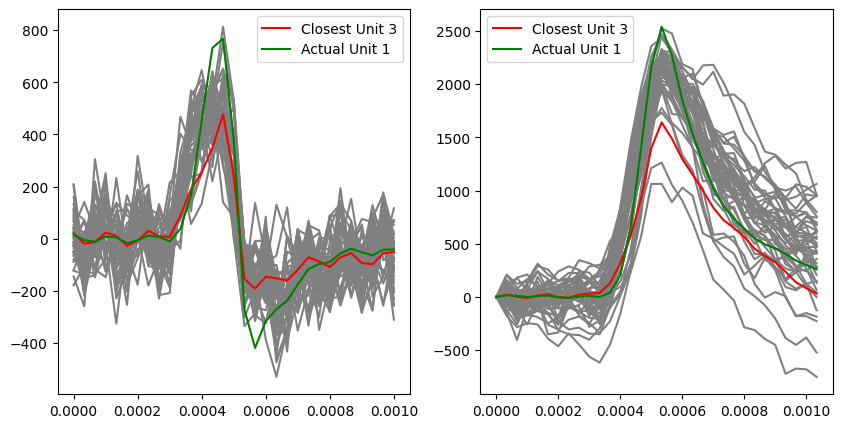

---------------------------------------------------                        
Different Bucket: Actual unit 1, Closest centroid unit 7, Number of spikes 14, Average dists 25.221 < 34.303


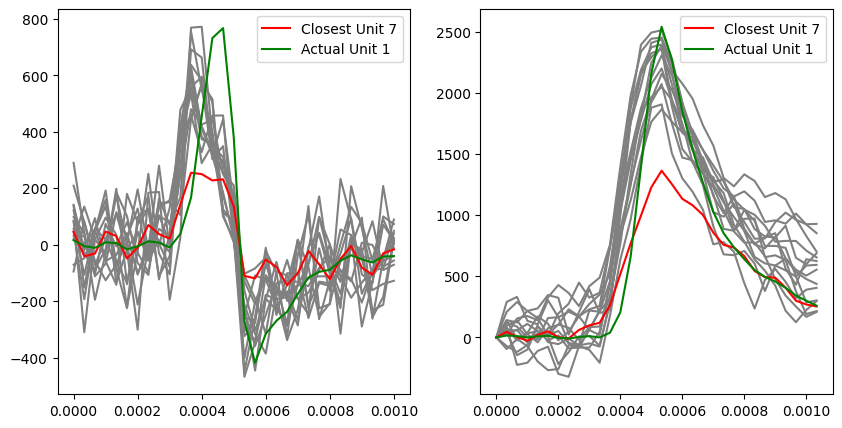

---------------------------------------------------                        
Different Bucket: Actual unit 1, Closest centroid unit 8, Number of spikes 4, Average dists 44.399 < 61.221


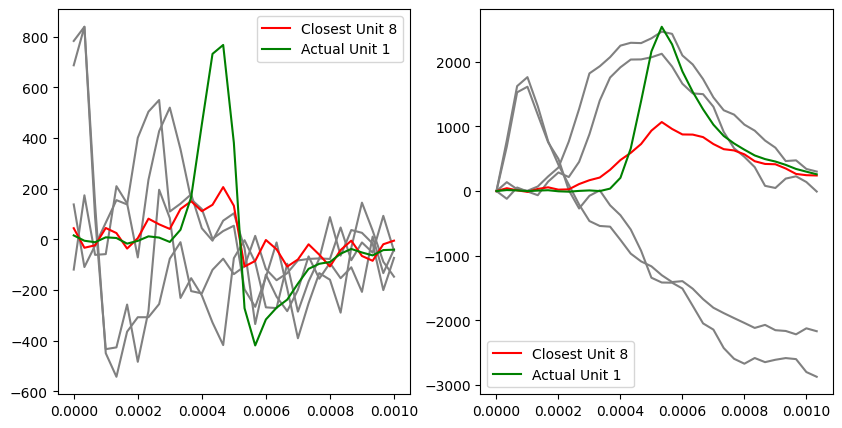

---------------------------------------------------                        
Different Bucket: Actual unit 1, Closest centroid unit 9, Number of spikes 2, Average dists 54.864 < 81.778


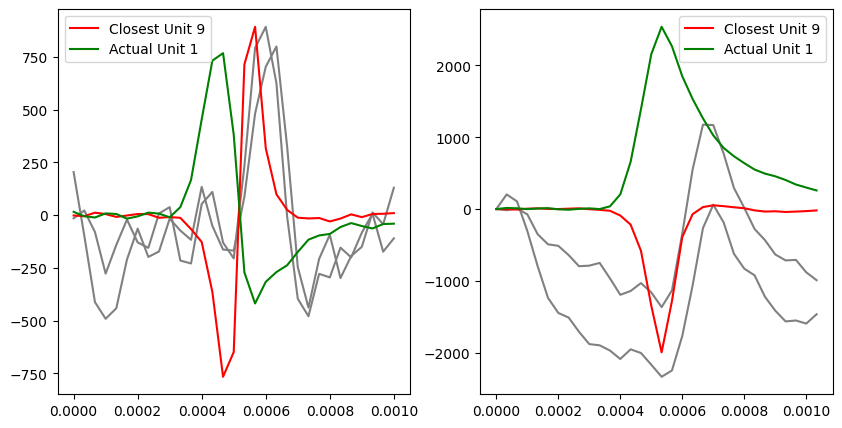

---------------------------------------------------                        
Different Bucket: Actual unit 2, Closest centroid unit 3, Number of spikes 6, Average dists 19.925 < 22.9


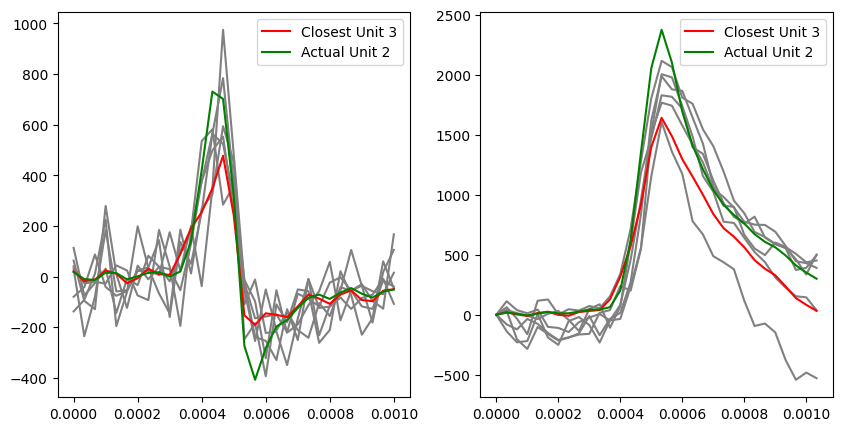

---------------------------------------------------                        
Different Bucket: Actual unit 2, Closest centroid unit 4, Number of spikes 1, Average dists 34.205 < 35.602


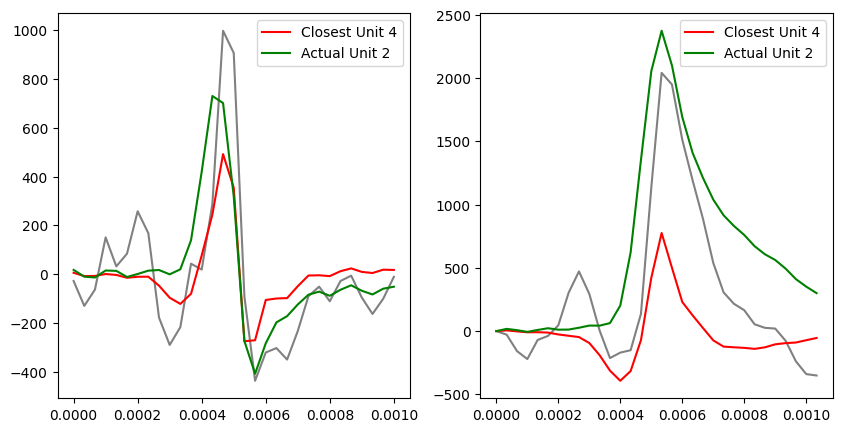

---------------------------------------------------                        
Different Bucket: Actual unit 2, Closest centroid unit 7, Number of spikes 8, Average dists 24.134 < 31.783


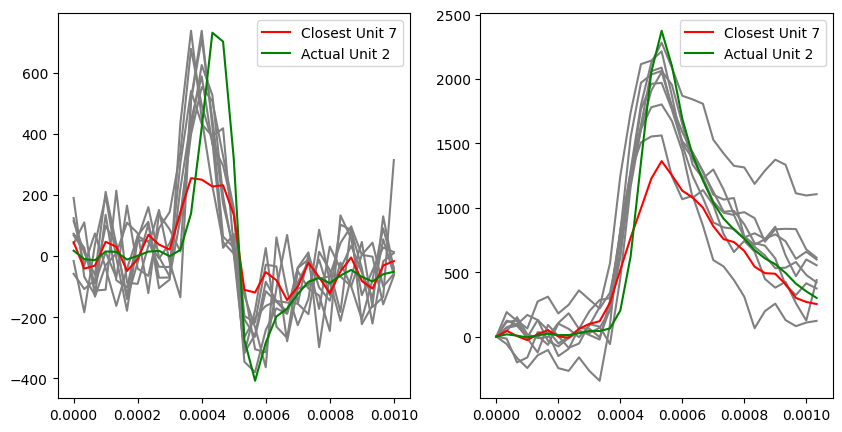

---------------------------------------------------                        
Different Bucket: Actual unit 3, Closest centroid unit 1, Number of spikes 1, Average dists 31.952 < 36.545


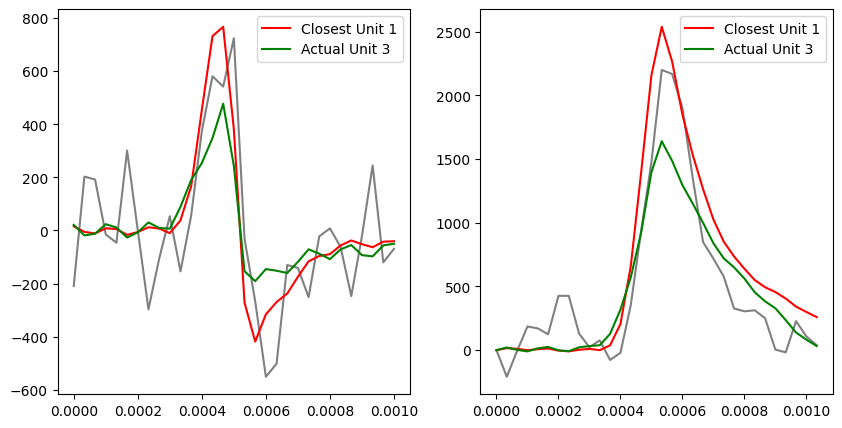

---------------------------------------------------                        
Different Bucket: Actual unit 3, Closest centroid unit 2, Number of spikes 25, Average dists 21.161 < 25.013


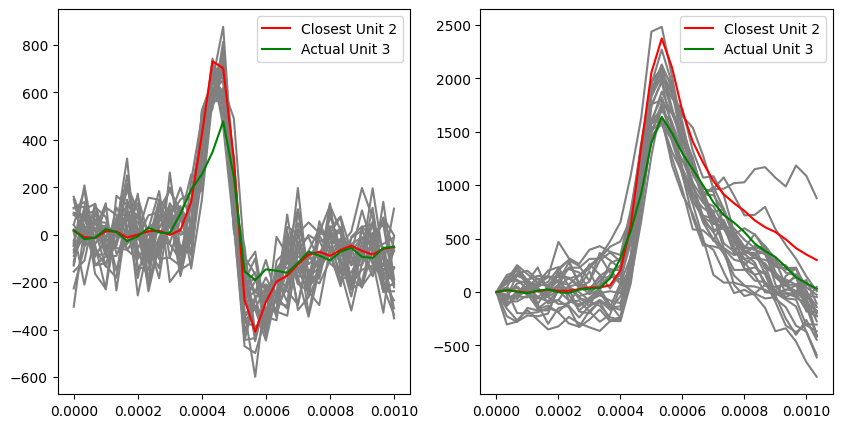

---------------------------------------------------                        
Different Bucket: Actual unit 3, Closest centroid unit 4, Number of spikes 47, Average dists 25.094 < 26.032


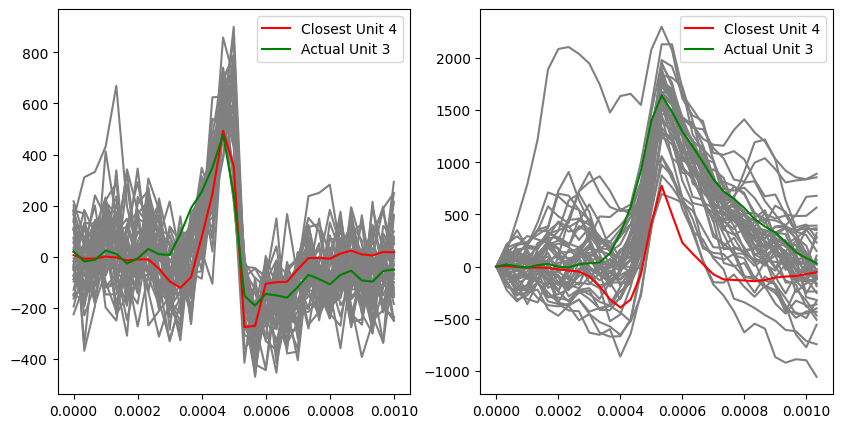

---------------------------------------------------                        
Different Bucket: Actual unit 3, Closest centroid unit 8, Number of spikes 63, Average dists 35.666 < 40.763


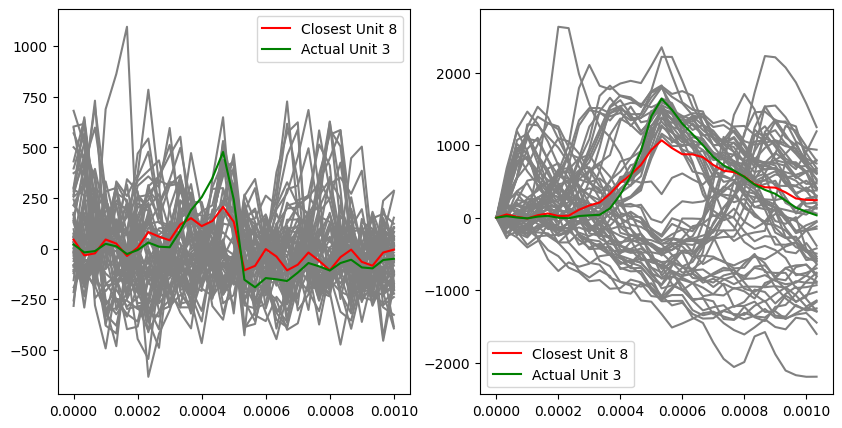

---------------------------------------------------                        
Different Bucket: Actual unit 4, Closest centroid unit 3, Number of spikes 10, Average dists 23.996 < 24.565


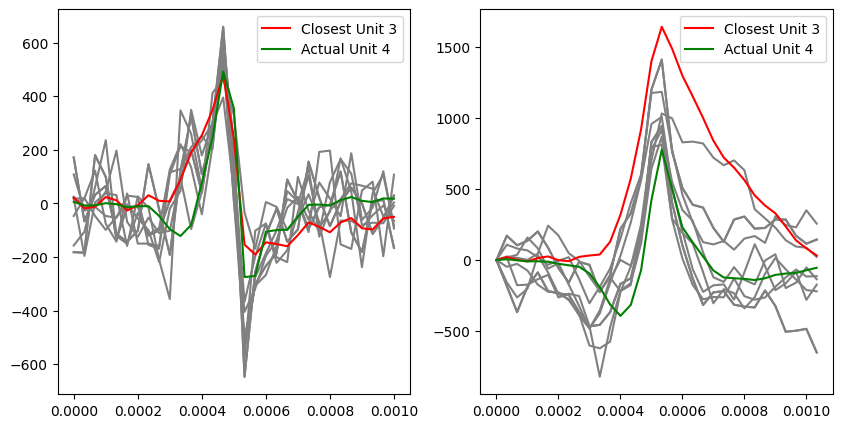

---------------------------------------------------                        
Different Bucket: Actual unit 4, Closest centroid unit 6, Number of spikes 36, Average dists 24.845 < 25.71


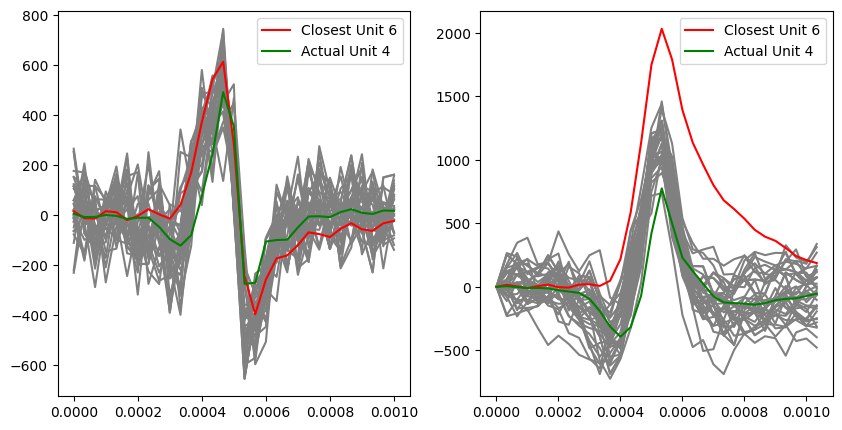

---------------------------------------------------                        
Different Bucket: Actual unit 4, Closest centroid unit 7, Number of spikes 3, Average dists 21.472 < 34.997


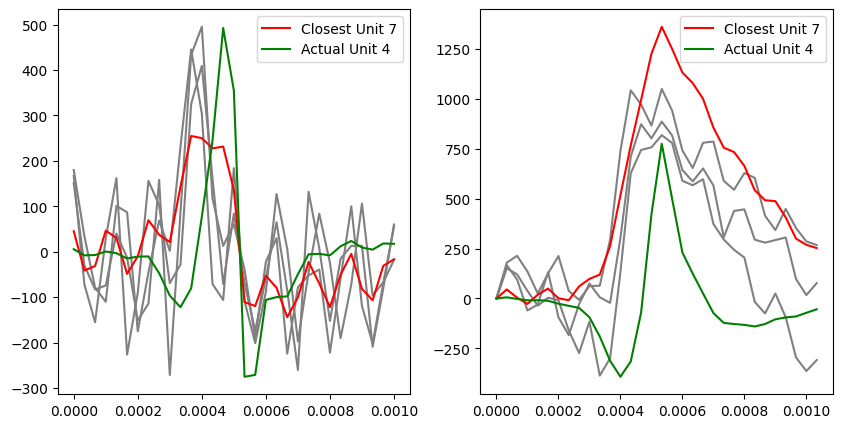

---------------------------------------------------                        
Different Bucket: Actual unit 4, Closest centroid unit 8, Number of spikes 128, Average dists 41.995 < 51.645


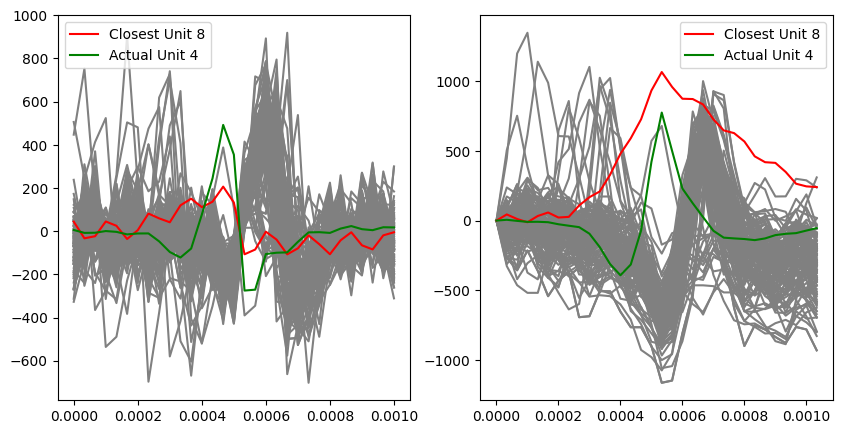

---------------------------------------------------                        
Different Bucket: Actual unit 4, Closest centroid unit 10, Number of spikes 11, Average dists 20.79 < 24.034


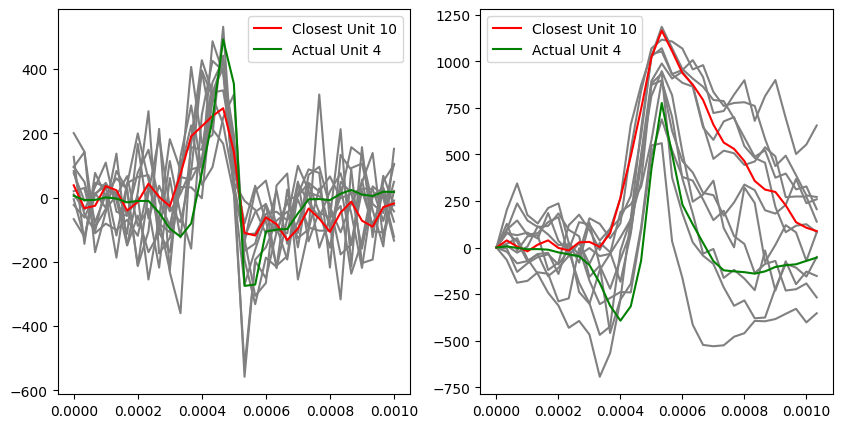

---------------------------------------------------                        
Different Bucket: Actual unit 5, Closest centroid unit 3, Number of spikes 139, Average dists 24.971 < 26.376


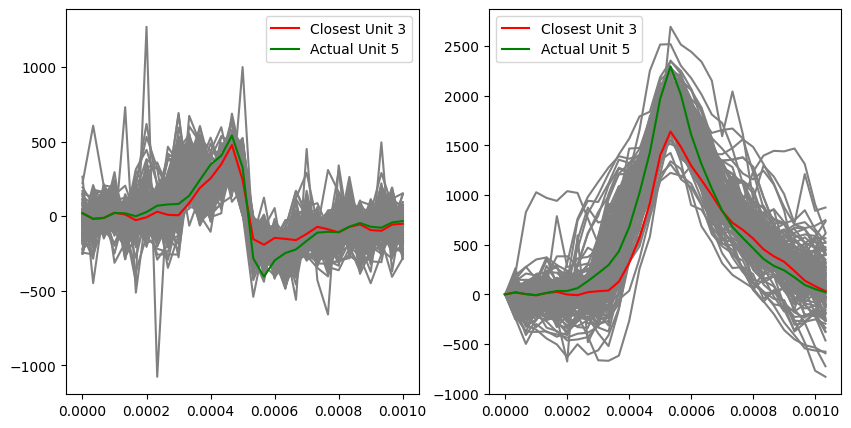

---------------------------------------------------                        
Different Bucket: Actual unit 5, Closest centroid unit 4, Number of spikes 1, Average dists 37.729 < 38.216


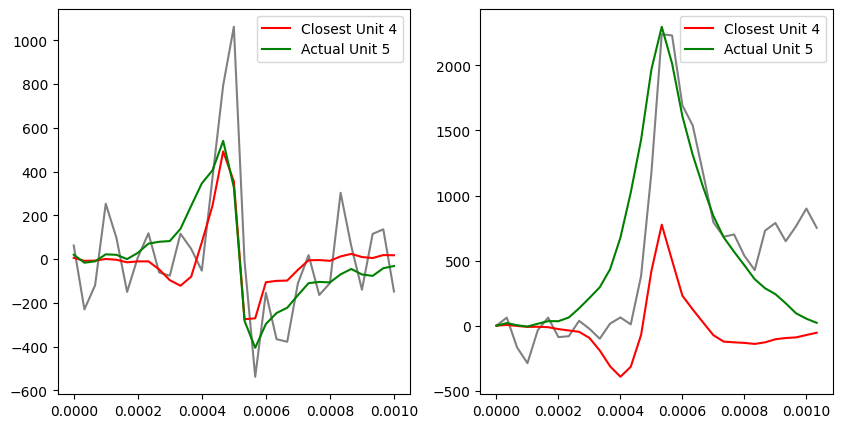

---------------------------------------------------                        
Different Bucket: Actual unit 5, Closest centroid unit 10, Number of spikes 3, Average dists 23.796 < 29.548


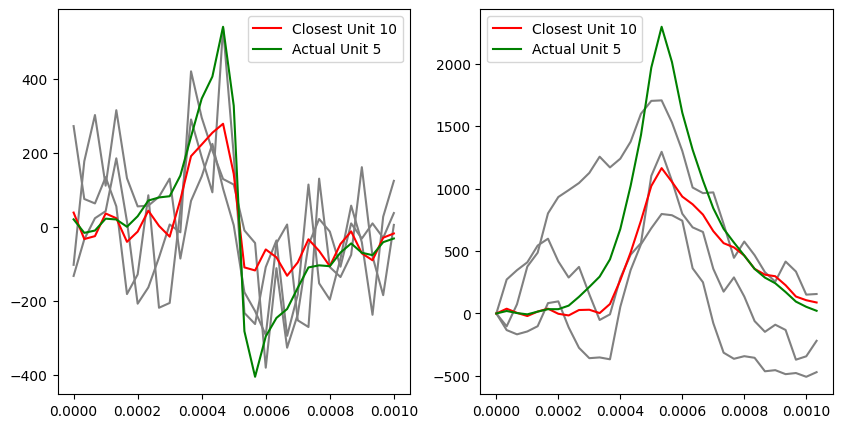

---------------------------------------------------                        
Different Bucket: Actual unit 6, Closest centroid unit 1, Number of spikes 432, Average dists 23.442 < 25.018


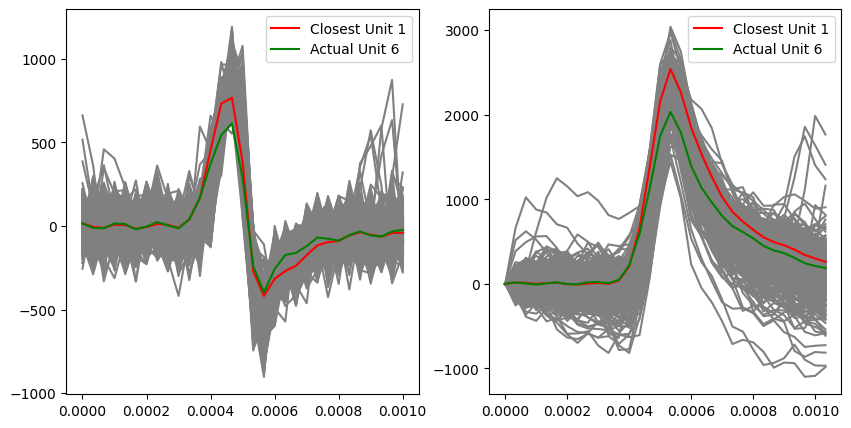

---------------------------------------------------                        
Different Bucket: Actual unit 6, Closest centroid unit 4, Number of spikes 11, Average dists 32.169 < 35.16


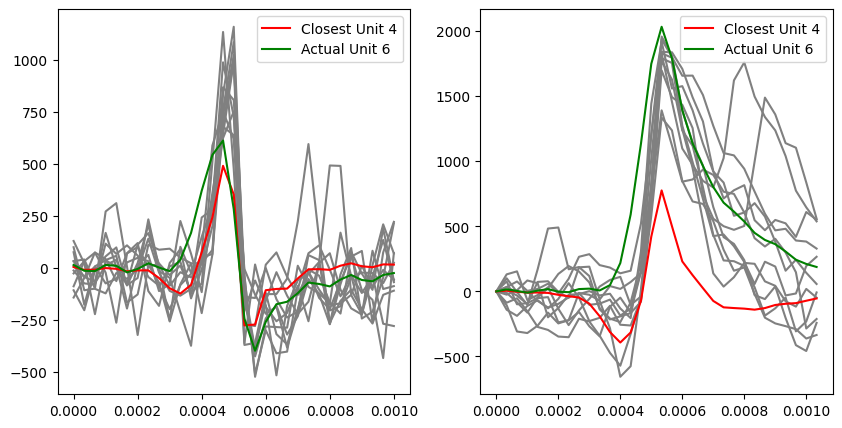

---------------------------------------------------                        
Different Bucket: Actual unit 6, Closest centroid unit 7, Number of spikes 257, Average dists 22.063 < 27.434


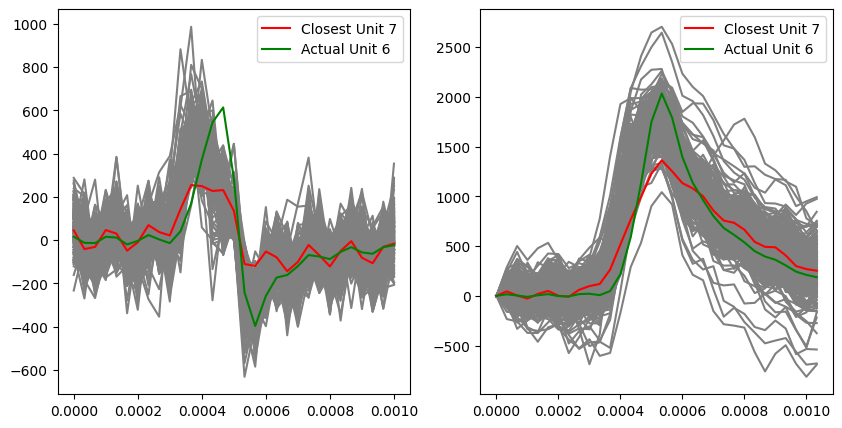

---------------------------------------------------                        
Different Bucket: Actual unit 6, Closest centroid unit 8, Number of spikes 11, Average dists 40.786 < 52.367


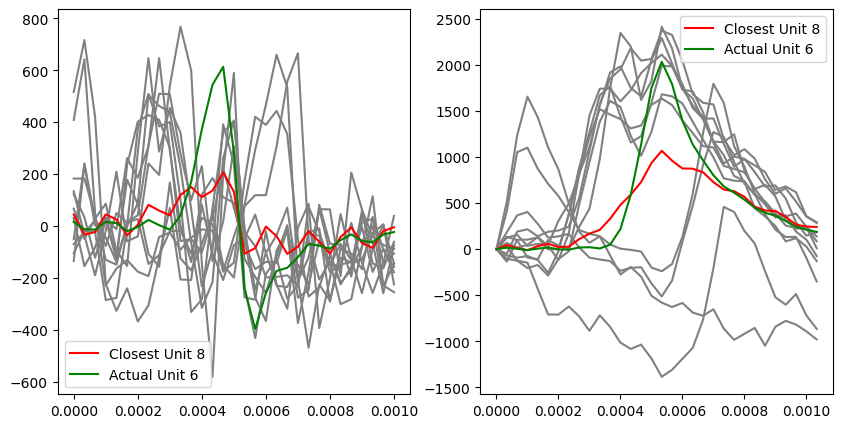

---------------------------------------------------                        
Different Bucket: Actual unit 6, Closest centroid unit 10, Number of spikes 8, Average dists 19.434 < 24.101


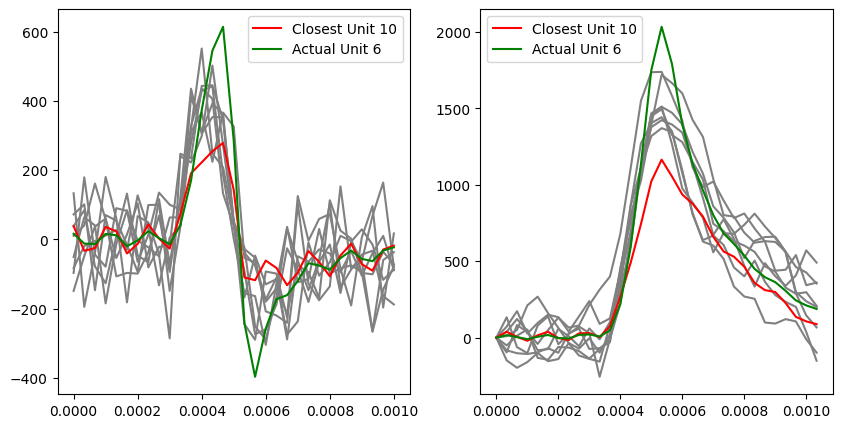

---------------------------------------------------                        
Different Bucket: Actual unit 7, Closest centroid unit 4, Number of spikes 3, Average dists 24.764 < 31.182


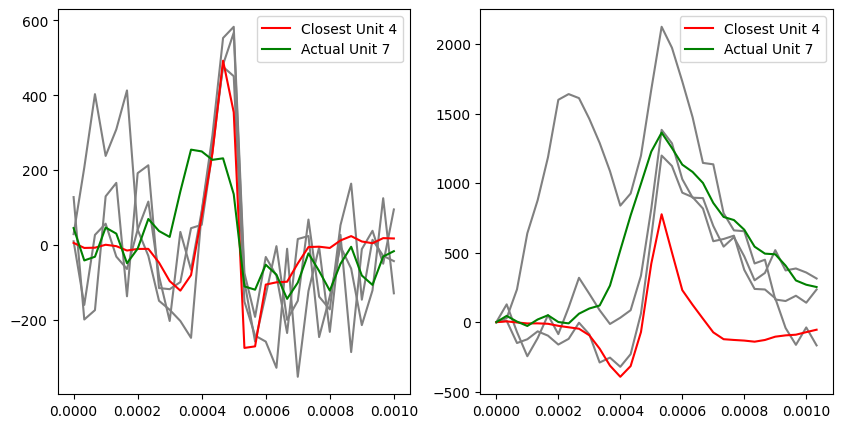

---------------------------------------------------                        
Different Bucket: Actual unit 7, Closest centroid unit 6, Number of spikes 5, Average dists 29.258 < 32.185


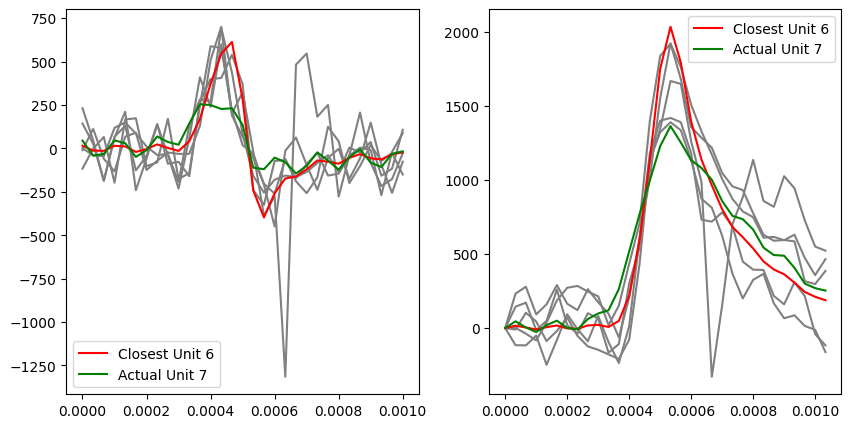

---------------------------------------------------                        
Different Bucket: Actual unit 8, Closest centroid unit 2, Number of spikes 1, Average dists 35.551 < 50.388


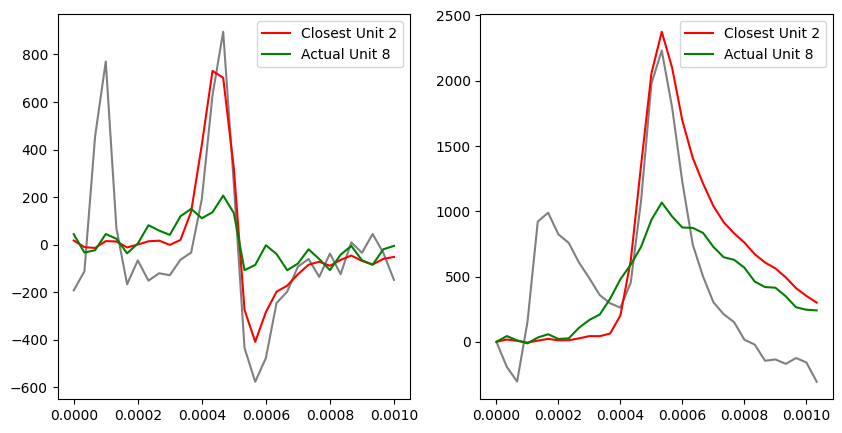

---------------------------------------------------                        
Different Bucket: Actual unit 8, Closest centroid unit 3, Number of spikes 222, Average dists 20.905 < 23.757


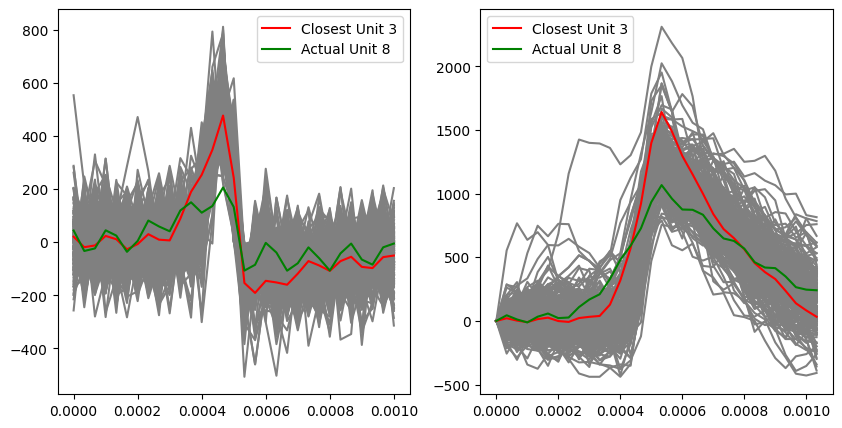

---------------------------------------------------                        
Different Bucket: Actual unit 8, Closest centroid unit 5, Number of spikes 3, Average dists 21.029 < 30.029


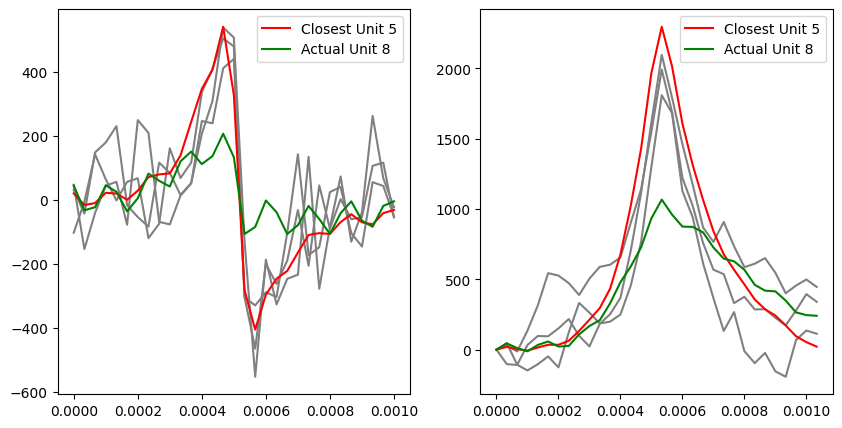

---------------------------------------------------                        
Different Bucket: Actual unit 8, Closest centroid unit 6, Number of spikes 7, Average dists 22.263 < 33.333


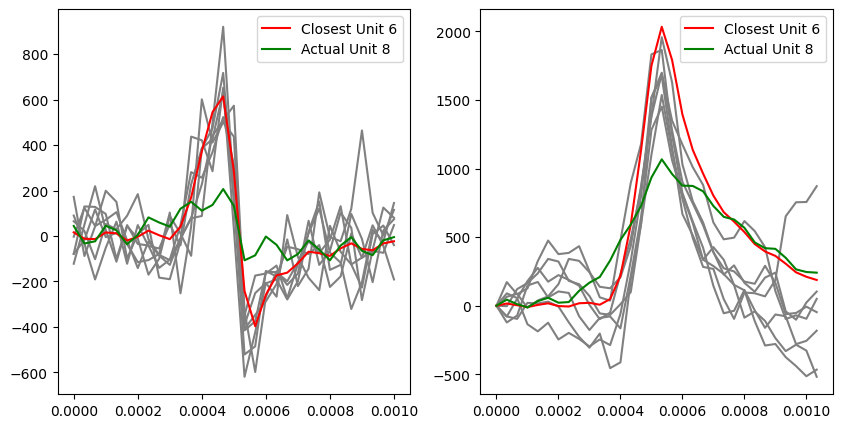

---------------------------------------------------                        
Different Bucket: Actual unit 10, Closest centroid unit 3, Number of spikes 828, Average dists 18.655 < 19.698


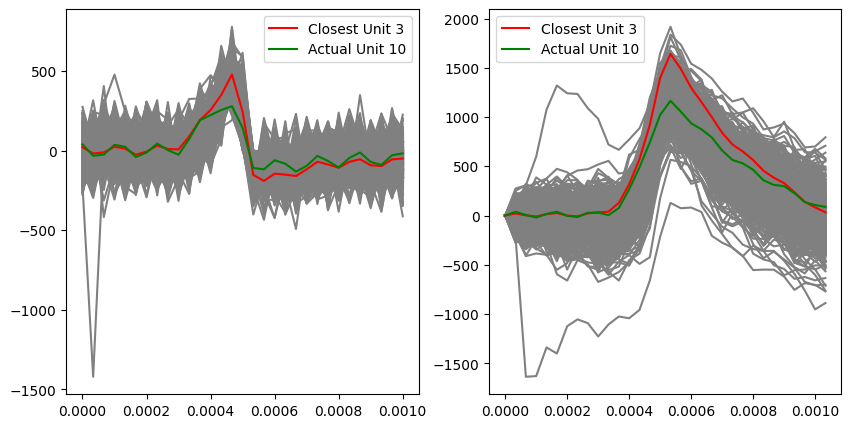

---------------------------------------------------                        
Different Bucket: Actual unit 10, Closest centroid unit 4, Number of spikes 39, Average dists 23.452 < 26.187


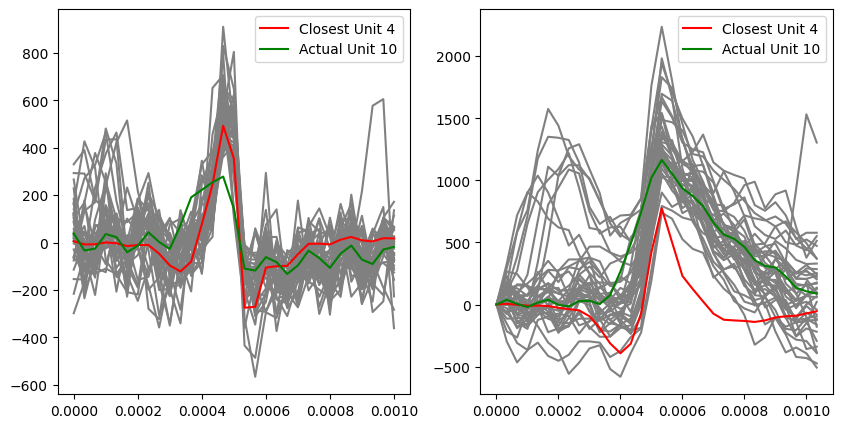

---------------------------------------------------                        
Different Bucket: Actual unit 10, Closest centroid unit 5, Number of spikes 1, Average dists 28.563 < 30.003


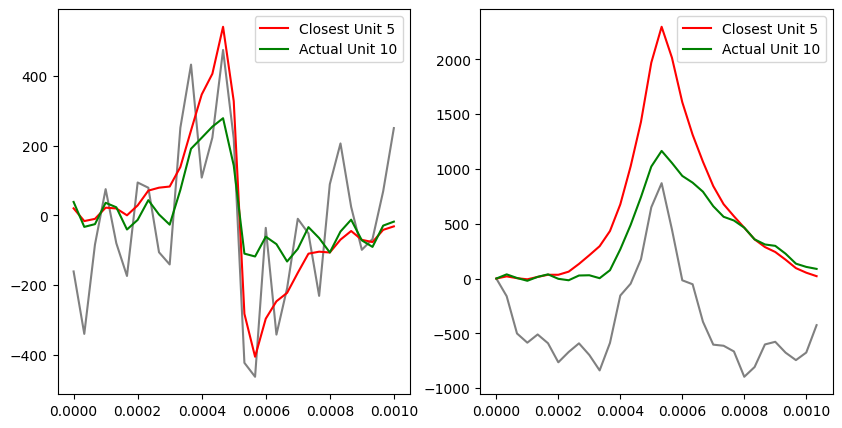

---------------------------------------------------                        
Different Bucket: Actual unit 10, Closest centroid unit 6, Number of spikes 1, Average dists 16.395 < 19.841


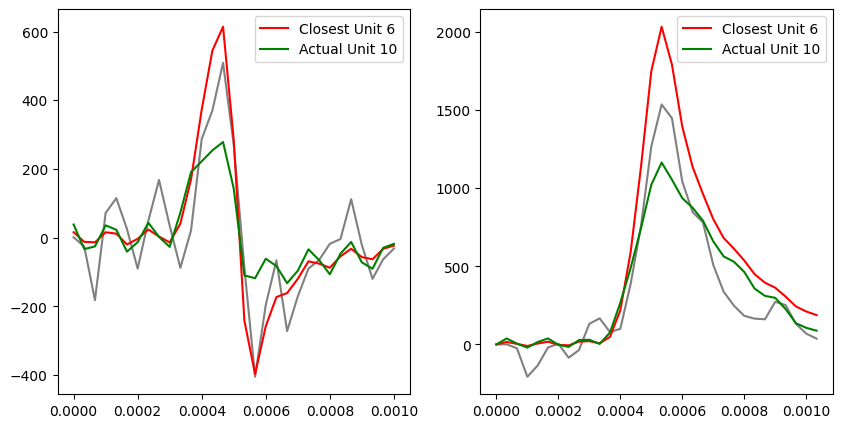

---------------------------------------------------                        
Different Bucket: Actual unit 10, Closest centroid unit 9, Number of spikes 1, Average dists 43.866 < 54.369


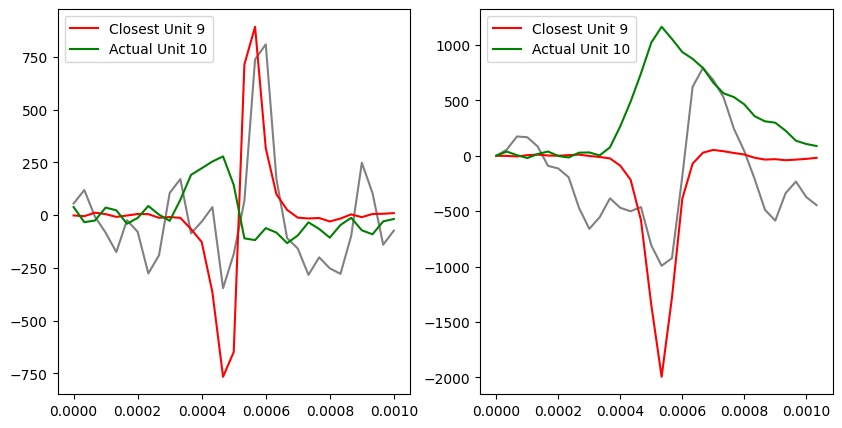

---------------------------------------------------                        
Similar Bucket: Actual unit 2, Closest centroid unit 1, Number of spikes 63, Average dists 24.227 < 25.143


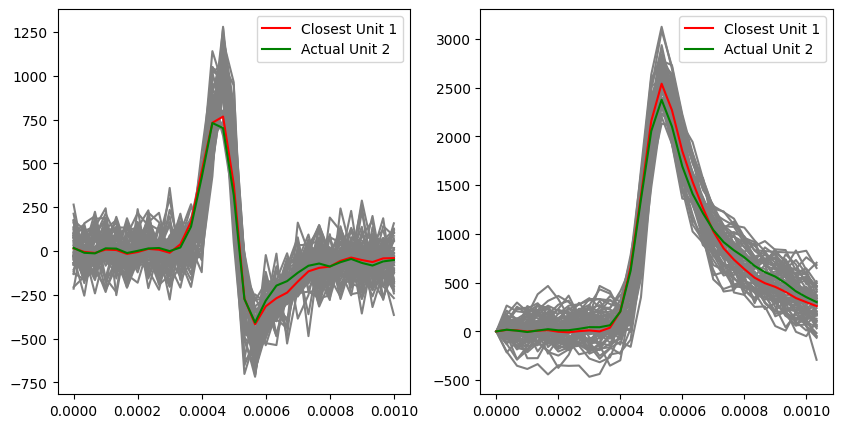

---------------------------------------------------                        
Similar Bucket: Actual unit 5, Closest centroid unit 1, Number of spikes 932, Average dists 25.27 < 29.819


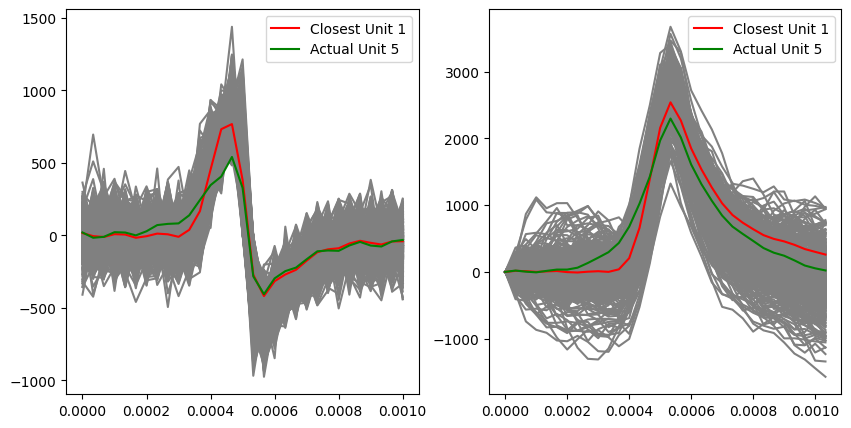

---------------------------------------------------                        
Similar Bucket: Actual unit 7, Closest centroid unit 10, Number of spikes 626, Average dists 17.227 < 17.95


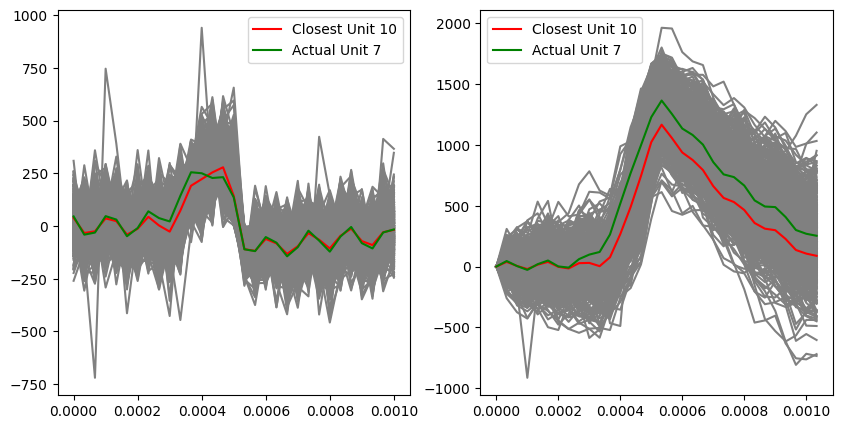

---------------------------------------------------                        
Similar Bucket: Actual unit 8, Closest centroid unit 7, Number of spikes 452, Average dists 19.455 < 20.948


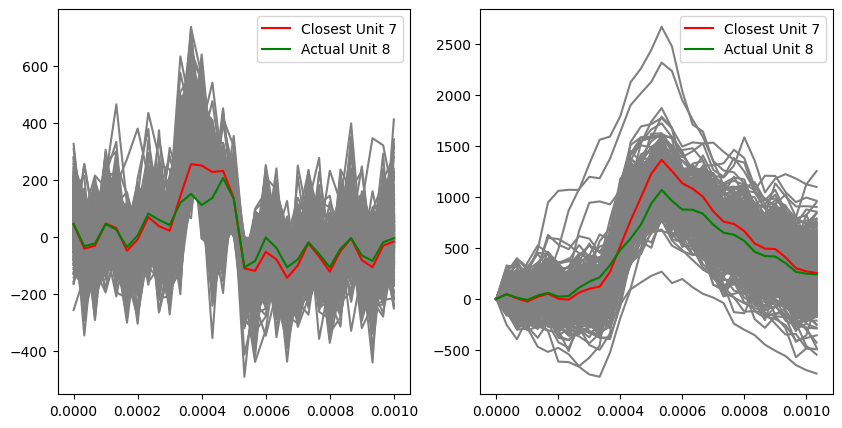

---------------------------------------------------                        
Similar Bucket: Actual unit 8, Closest centroid unit 10, Number of spikes 678, Average dists 18.188 < 19.763


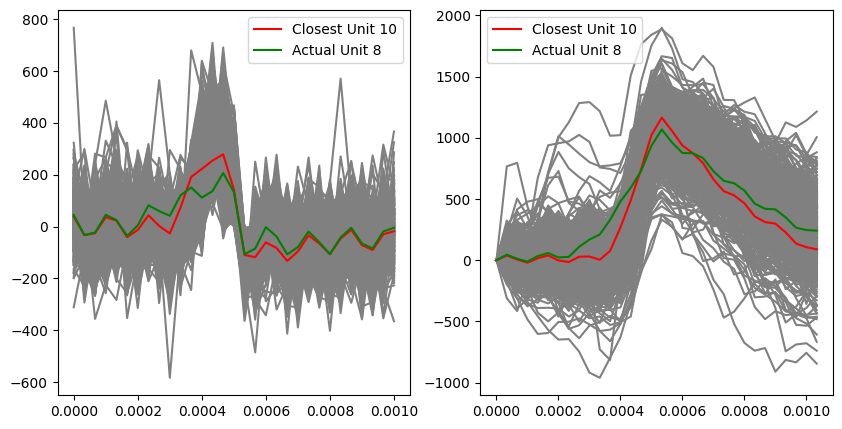

2379 [244, 573, 1149, 1308, 1640]
---------------------------------------------------                        
Different Bucket: Actual unit 4, Closest centroid unit 6, dists: 33.562 < 34.718


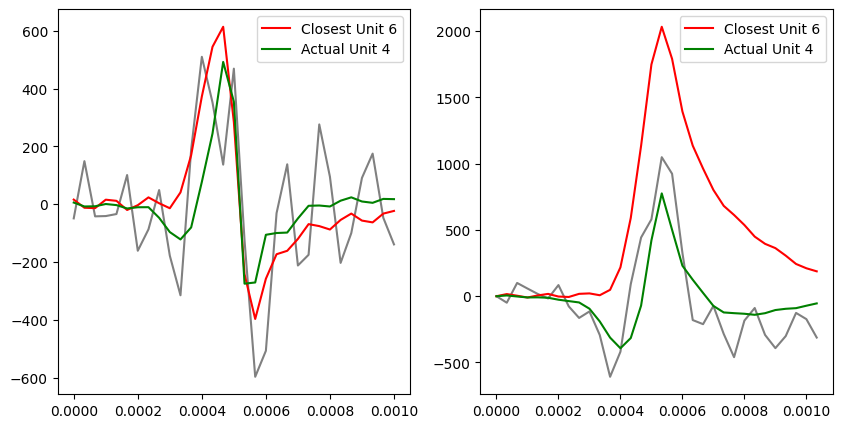

---------------------------------------------------                        
Different Bucket: Actual unit 6, Closest centroid unit 1, dists: 33.372 < 34.226


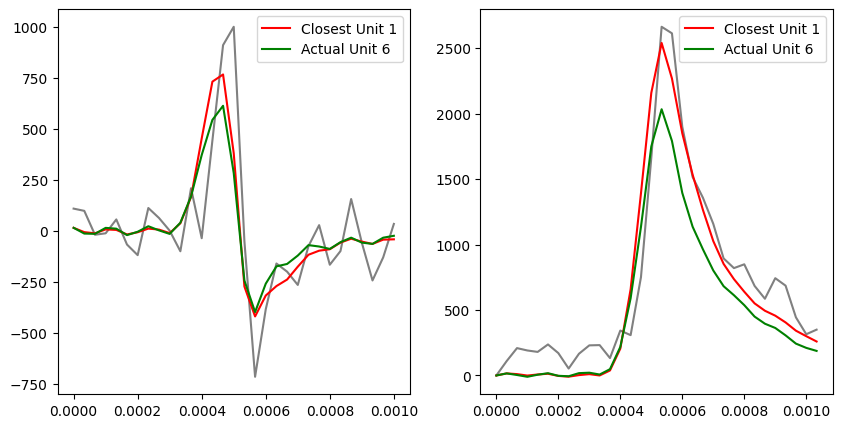

---------------------------------------------------                        
Different Bucket: Actual unit 6, Closest centroid unit 7, dists: 25.171 < 26.855


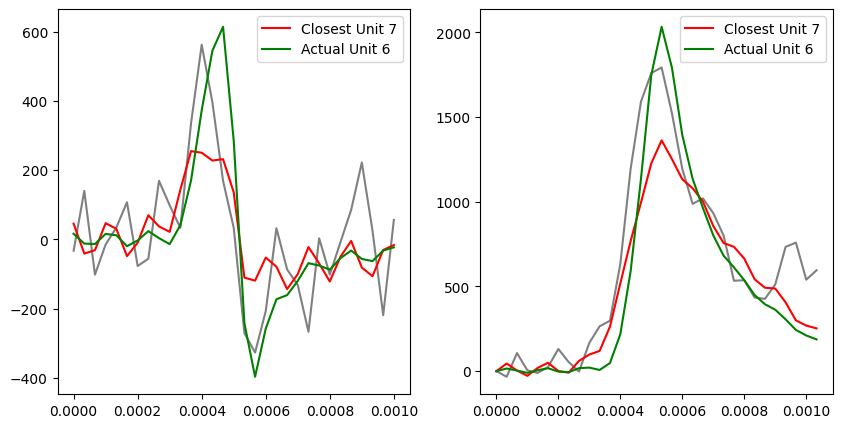

---------------------------------------------------                        
Different Bucket: Actual unit 8, Closest centroid unit 3, dists: 17.176 < 18.311


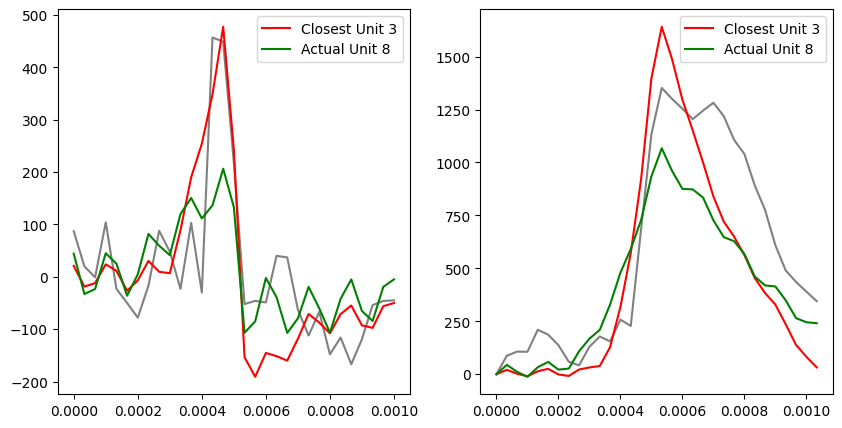

---------------------------------------------------                        
Different Bucket: Actual unit 10, Closest centroid unit 3, dists: 17.882 < 19.851


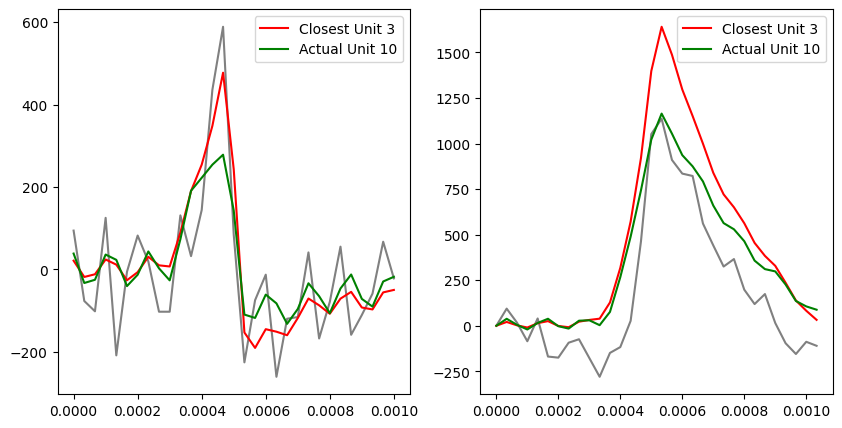

2751 [25, 910, 1396, 2190, 2740]
---------------------------------------------------                        
Similar Bucket: Actual unit 2, Closest centroid unit 1, dists: 23.436 < 24.037


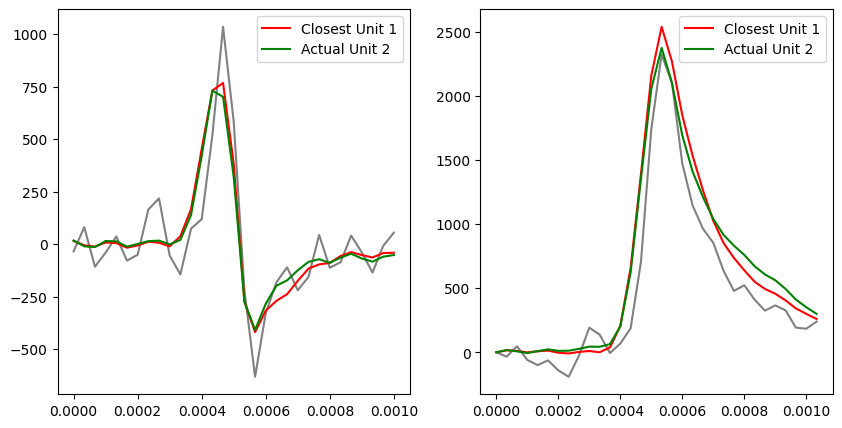

---------------------------------------------------                        
Similar Bucket: Actual unit 5, Closest centroid unit 1, dists: 31.375 < 33.647


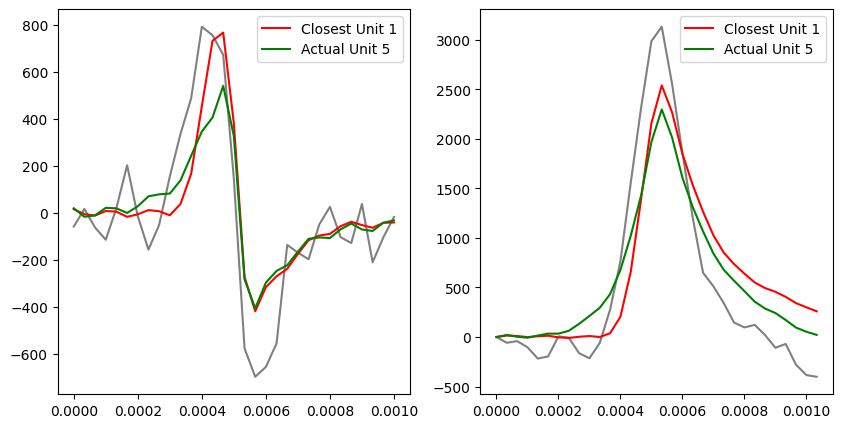

---------------------------------------------------                        
Similar Bucket: Actual unit 7, Closest centroid unit 10, dists: 19.493 < 20.827


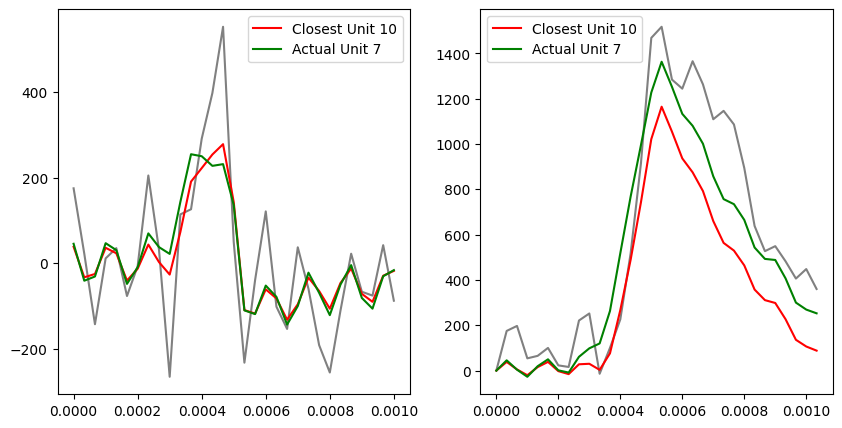

---------------------------------------------------                        
Similar Bucket: Actual unit 8, Closest centroid unit 10, dists: 25.679 < 26.65


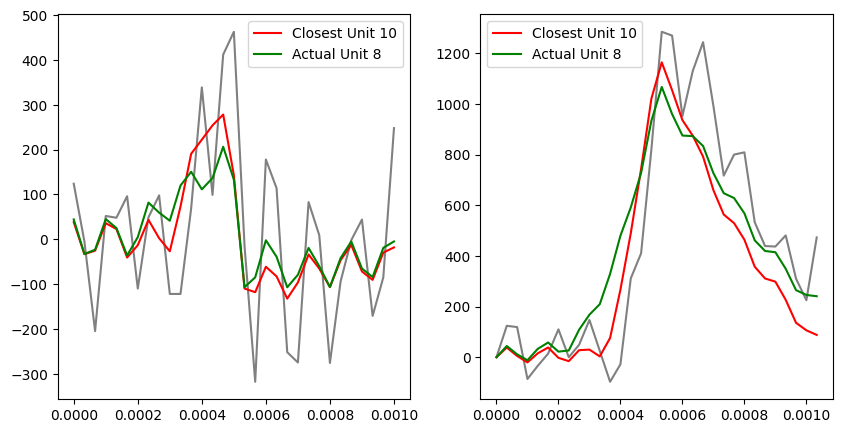

---------------------------------------------------                        
Similar Bucket: Actual unit 8, Closest centroid unit 10, dists: 21.163 < 21.542


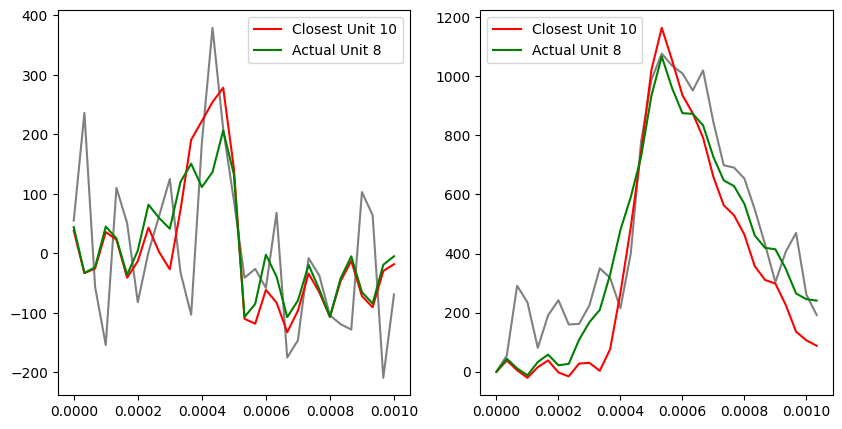

In [ ]:
def plot_waveform(waveform, waveform_op):
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, len(waveform) / 30000, 1/30000), waveform*-1, color="gray")
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, len(waveform_op) / 30000, 1/30000), waveform_op*-1, color="gray")

def plot_centroids(centroids_bucket, closest_index, actual_index, use_first=1):
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, len(centroids_bucket[closest_index - use_first][0]) / 30000, 1/30000), centroids_bucket[closest_index - use_first][0]*-1, label=f"Closest Unit {closest_index}", color="red")
    plt.legend()
    plt.plot(np.arange(0, len(centroids_bucket[actual_index - use_first][0]) / 30000, 1/30000), centroids_bucket[actual_index - use_first][0]*-1, label=f"Actual Unit {actual_index}", color="green")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, len(centroids_bucket[closest_index - use_first][1]) / 30000, 1/30000), centroids_bucket[closest_index - use_first][1]*-1, label=f"Closest Unit {closest_index}", color="red")
    plt.legend()
    plt.plot(np.arange(0, len(centroids_bucket[actual_index - use_first][1]) / 30000, 1/30000), centroids_bucket[actual_index - use_first][1]*-1, label=f"Actual Unit {actual_index}", color="green")
    plt.legend()
    plt.show()

def print_bucket(centroids_bucket, bucket, bucket_name, use_first=1):
    plt.rcParams['figure.figsize'] = [10, 5]
    for actual_index in range(num_units):
        for closest_index  in range(num_units):
            if bucket[actual_index][closest_index]:
                avg_min_dist = round(sum([entry[2] for entry in bucket[actual_index][closest_index]])/len(bucket[actual_index][closest_index]), 3)
                avg_actual_dist = round(sum([entry[3] for entry in bucket[actual_index][closest_index]])/len(bucket[actual_index][closest_index]), 3)
                print(f"---------------------------------------------------\
                        \n{bucket_name}: Actual unit {actual_index}, Closest centroid unit {closest_index}, Number of spikes {len(bucket[actual_index][closest_index])}, Average dists {avg_min_dist} < {avg_actual_dist}")
                for waveform, waveform_op, min_distance, actual_dist in bucket[actual_index][closest_index]:
                    plot_waveform(waveform, waveform_op)
                plot_centroids(centroids_bucket, closest_index, actual_index, use_first)
    plt.rcParams['figure.figsize'] = [6.4, 4.8] #Restore plots to their default size

def print_individuals(centroids_bucket, bucket, bucket_name, use_first=1):
    plt.rcParams['figure.figsize'] = [10, 5]
    num_spikes = 0
    for actual_index in range(num_units):
        for closest_index  in range(num_units):
            num_spikes += len(bucket[actual_index][closest_index])
    indices = sorted(random.sample(range(num_spikes), 5))
    print(num_spikes, indices)
    i = 0
    cur_spikes = 0

    for actual_index in range(num_units):
        for closest_index  in range(num_units):
            if bucket[actual_index][closest_index]:
                while cur_spikes + len(bucket[actual_index][closest_index]) > indices[i]:
                    waveform, waveform_op, min_distance, actual_dist = bucket[actual_index][closest_index][indices[i] - cur_spikes]
                    print(f"---------------------------------------------------\
                        \n{bucket_name}: Actual unit {actual_index}, Closest centroid unit {closest_index}, dists: {min_distance} < {actual_dist}")
                    plot_waveform(waveform, waveform_op)
                    plot_centroids(centroids_bucket, closest_index, actual_index, use_first)
                    i += 1
                    if i == len(indices):
                        return
                cur_spikes += len(bucket[actual_index][closest_index])

    plt.rcParams['figure.figsize'] = [6.4, 4.8] #Restore plots to their default size

def get_buckets(details, channel_map, use_differences, distance_metric, n_bits=-1, width=30, use_first=1, use_haar=use_haar):
    centroids = compute_centroids(channel_map, use_differences, n_bits, width, use_first, use_haar)
    centroids_op = compute_centroids(channel_map, (use_differences+1)%2, n_bits, width, use_first, use_haar)
    different_bucket = [[[] for j in range(num_units)] for i in range(num_units)]
    similar_bucket = [[[] for j in range(num_units)] for i in range(num_units)]
    for i in range(use_first, num_units):
        for index in all_indices[i]:
            waveform =  process_waveform(downsampled_data, all_times[index], channel_map[i], use_differences, width, use_haar)
            # Waveform with the opposite decision made about taking first differences or not
            waveform_op =  process_waveform(downsampled_data, all_times[index], channel_map[i], (use_differences+1)%2, width, use_haar)

            min_centroid_index, min_distance, actual_dist = get_closest_centroid(centroids, waveform, distance_metric, i, use_first)
            if  i - use_first != min_centroid_index:
                if details[i][min_centroid_index+use_first] / sum(details[i]) <= 0.03:
                    different_bucket[i][min_centroid_index+use_first].append((waveform, waveform_op, min_distance, actual_dist))
                elif details[i][min_centroid_index+use_first] / details[i][i] >= 1/3:
                    similar_bucket[i][min_centroid_index+use_first].append((waveform, waveform_op, min_distance, actual_dist))
    centroids_bucket = [(centroids[i], centroids_op[i]) for i in range(len(centroids))]
    return different_bucket, similar_bucket, centroids_bucket

print(details)
different_bucket, similar_bucket, centroids_bucket = get_buckets(details, channel_map, 1, "EUCLIDEAN", -1, 32, 1, False)
print_bucket(centroids_bucket, different_bucket, "Different Bucket", 1)
print_bucket(centroids_bucket, similar_bucket, "Similar Bucket", 1)
print_individuals(centroids_bucket, different_bucket, "Different Bucket", 1)
print_individuals(centroids_bucket, similar_bucket, "Similar Bucket", 1)

In [ ]:
def compute_intrinsic_accuracy(channel_map, use_differences, use_first, n_bits, width=30):
    patterns = {}
    downsampled_data = downsample_orig_data(orig_data, n_bits)
    for i in range(use_first, num_units):
        s = np.zeros(width-use_differences)
        for index in all_indices[i]:
            waveform =  process_waveform(downsampled_data, all_times[index], channel_map[i], use_differences)
            pattern = tuple(waveform)


            if pattern not in patterns:
                patterns[pattern] = np.zeros(num_units)
            patterns[pattern][i] += 1
    # print(len(patterns))
    #Compute intrinsic accuracy
    num_matched = 0
    num_total = 0

    #Print 10 rows from the Q-table
    # k = 0
    # for pattern in sorted(patterns.keys()):
    #     if k == 10:
    #         break
    #     k += 1
    #     print(pattern, patterns[pattern])
    label_dominant = np.zeros(num_units)
    for value in patterns.values():
        max_index = np.argmax(value)
        label_dominant[max_index] = max(label_dominant[max_index], max(value))
        num_matched += max(value)
        num_total += sum(value)
    print(f"Intrinsic Accuracy {use_differences, use_first, n_bits}:", num_matched/num_total, sum(label_dominant)/num_total)


In [ ]:
#Create Q-Table
n_bits = 1

# compute_intrinsic_accuracy(channel_map, 0, 0, -1)
# compute_intrinsic_accuracy(channel_map, 1, 0, -1)
# compute_intrinsic_accuracy(channel_map, 0, 0, 8)
# compute_intrinsic_accuracy(channel_map, 1, 0, 8)
# compute_intrinsic_accuracy(channel_map, 0, 0, 4)
# compute_intrinsic_accuracy(channel_map, 1, 0, 4)
# compute_intrinsic_accuracy(channel_map, 0, 0, 1)
# compute_intrinsic_accuracy(channel_map, 1, 0, 1)

# compute_intrinsic_accuracy(channel_map, 0, 1, -1)
# compute_intrinsic_accuracy(channel_map, 1, 1, -1)
# compute_intrinsic_accuracy(channel_map, 0, 1, 8)
# compute_intrinsic_accuracy(channel_map, 1, 1, 8)
# compute_intrinsic_accuracy(channel_map, 0, 1, 7)
# compute_intrinsic_accuracy(channel_map, 1, 1, 7)
# compute_intrinsic_accuracy(channel_map, 0, 1, 6)
# compute_intrinsic_accuracy(channel_map, 1, 1, 6)
# compute_intrinsic_accuracy(channel_map, 0, 1, 5)
# compute_intrinsic_accuracy(channel_map, 1, 1, 5)
# compute_intrinsic_accuracy(channel_map, 0, 1, 4)
# compute_intrinsic_accuracy(channel_map, 1, 1, 4)